# Census Income - da li osoba zarađuje preko 50K godišnje?

In [1]:
%pip install seaborn
%pip install category_encoders
%pip install imblearn
%pip install lazypredict
%pip install lightgbm
%pip install git+https://github.com/viisar/brew.git
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgbm
from sklearn.linear_model import Lasso
from brew.base import Ensemble
from brew.base import EnsembleClassifier
from brew.combination.combiner import Combiner

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/viisar/brew.git to c:\program files\kmspico\temp\pip-req-build-l7n00w5r
  Resolved https://github.com/viisar/brew.git to commit 83a349788ae0a3c92a6a5e5d501531197d70a4d4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/viisar/brew.git 'C:\Program Files\KMSpico\temp\pip-req-build-l7n00w5r'

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Prvo ćemo izvršiti učitavanje podataka i proveriti koje klase postoje.

In [2]:
dataset = fetch_ucirepo(id=2) 

In [3]:
# Izvlacenje podataka u obliku dataframe-a  
x = dataset.data.features

In [4]:
# Izvlacenje targeta u obliku np.array-a 
y = np.array(dataset.data.targets)
y = np.reshape(y, (y.shape[0]))
print(np.unique(y))

['<=50K' '<=50K.' '>50K' '>50K.']


Može se primetiti da, iako imamo 4 jedinstvene vrednosti, zapravo imamo samo dve klase - onu koja zarađuje manje do 50K godišnje, i onu koja zarađuje više od toga. Zbog toga ćemo izvršiti modifikaciju labela.

In [5]:
# Sredjivanje labela
# 0 - <=50K
# 1 - >50K

labels = np.zeros(y.shape[0]).astype(np.uint8)
labels[np.where(y=='>50K')] = 1
labels[np.where(y=='>50K.')] = 1

Nakon toga, proverićemo balansiranost dataset-a.

<BarContainer object of 2 artists>

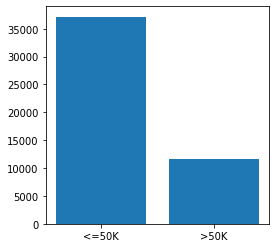

In [6]:
# Provera da li je dataset balansiran (nije) 
# Ukupno 48842 podatka
zeros = np.sum((labels==0))
ones = np.sum((labels==1))
names = ['<=50K', '>50K']
values = [zeros, ones]
plt.figure(figsize=(4,4))
plt.bar(names, values)

Proverićemo i strukturu dataset-a.

In [7]:
# Provera podataka (koliko null vrednosti postoji i sl.)
print(x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB
None


In [8]:
# Dodavanje labela u dataframe.
x['label'] = labels

## Vizuelizacija i analiza podataka

Sledeće što ćemo uraditi jeste vizuelizacija podataka i outlier-a (za numeričke podatke).

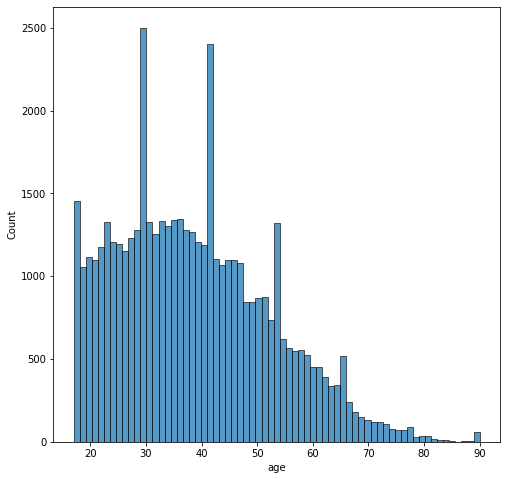

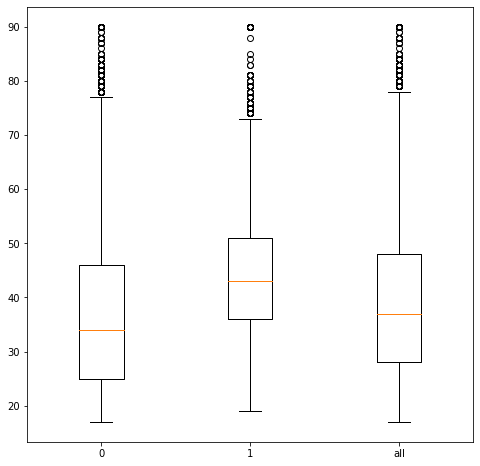

In [9]:
plt.figure(figsize=(8,8))
sns.histplot(x, x='age')
plt.show()

plt.figure(figsize=(8,8))
data = [x[x['label'] == 0]['age'], x[x['label'] == 1]['age'], x['age']]
plt.boxplot(data, labels=['0', '1', 'all'])
plt.show()

Outlier-i u koloni "age" nisu izbačeni prilikom analize jer nisu mnogobrojni i ni jedan od njih nije nerealno veliki ili mali. Takođe, njihovo izbacivanje utiče kasnije na kvalitet kreiranog modela.

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Unknown              1836
Self-emp-inc         1695
Federal-gov          1432
NaN                   963
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


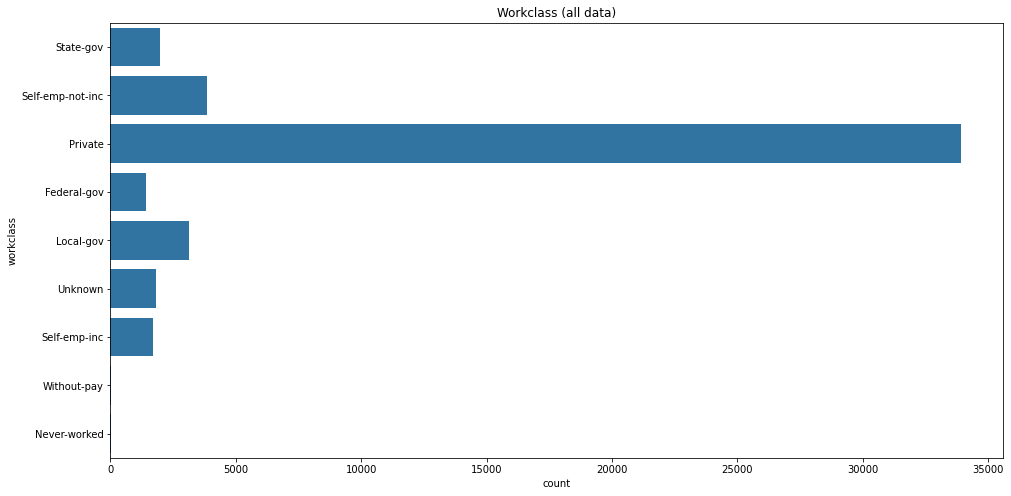

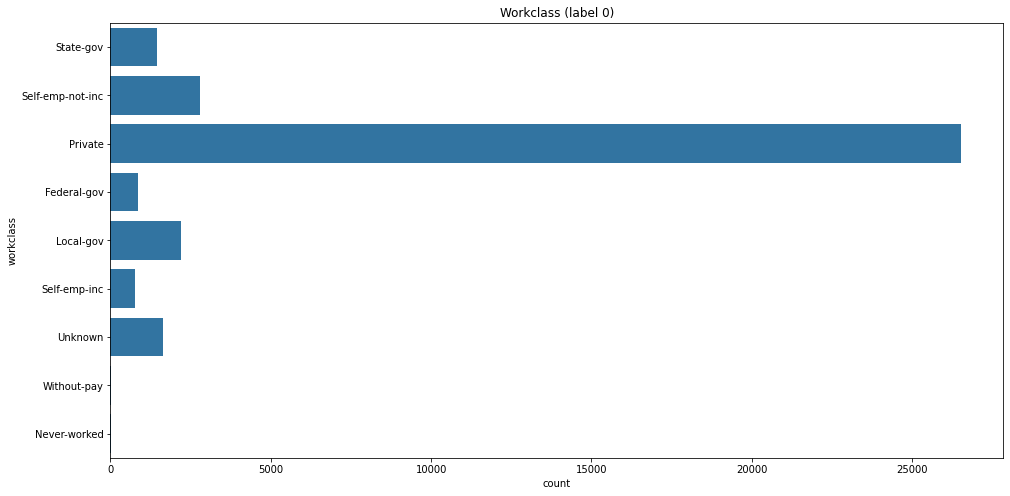

[Text(0.5, 1.0, 'Workclass (label 1)')]

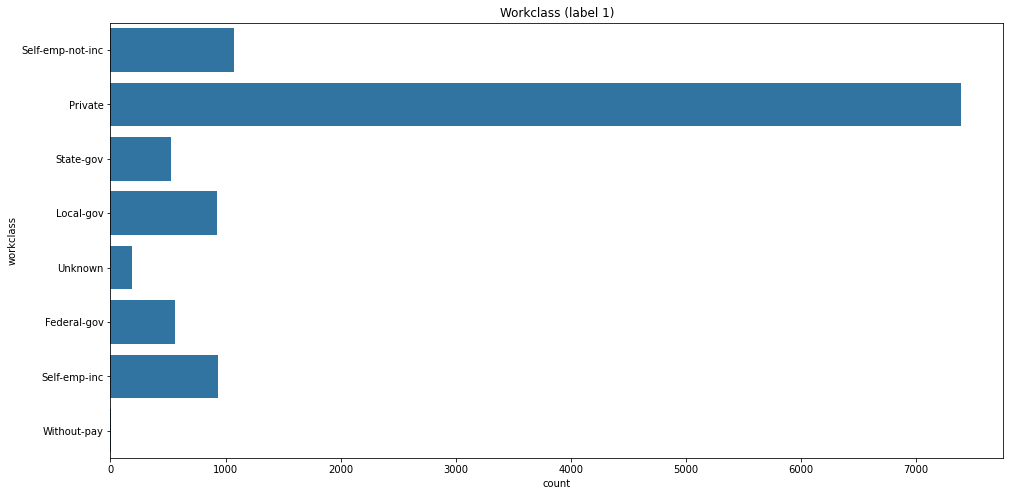

In [10]:
x['workclass'].replace('?', 'Unknown', inplace=True)
print(x['workclass'].value_counts(dropna=False))
plt.figure(figsize=(16,8))
sns.countplot(x, y='workclass').set(title='Workclass (all data)')
plt.show()
plt.figure(figsize=(16,8))
sns.countplot(x[x['label'] == 0], y='workclass').set(title='Workclass (label 0)')
plt.show()
plt.figure(figsize=(16,8))
sns.countplot(x[x['label'] == 1], y='workclass').set(title='Workclass (label 1)')

HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64


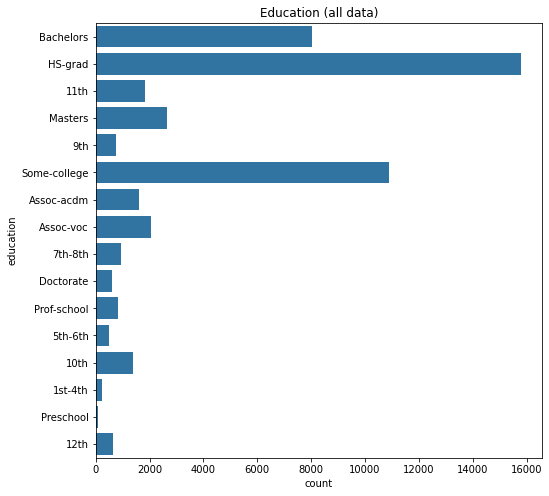

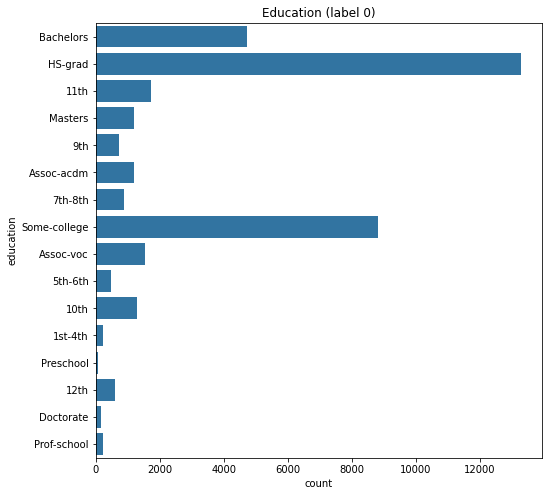

[Text(0.5, 1.0, 'Education (label 1)')]

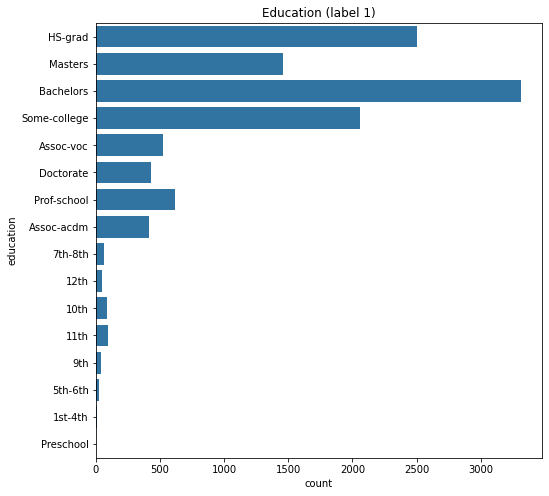

In [11]:
print(x['education'].value_counts(dropna=False))
plt.figure(figsize=(8,8))
sns.countplot(x, y='education').set(title='Education (all data)')
plt.show()
plt.figure(figsize=(8,8))
sns.countplot(x[x['label'] == 0], y='education').set(title='Education (label 0)')
plt.show()
plt.figure(figsize=(8,8))
sns.countplot(x[x['label'] == 1], y='education').set(title='Education (label 1)')

In [12]:
# Oodbacujemo fnlwgt kolonu, jer ona ne sadrzi korisne informacije.
# (objasnjava koji procenat populacije ima isti set feature-a)
x = x.drop('fnlwgt', axis=1)

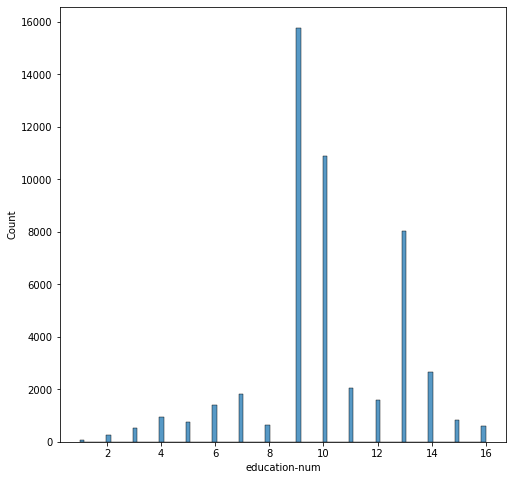

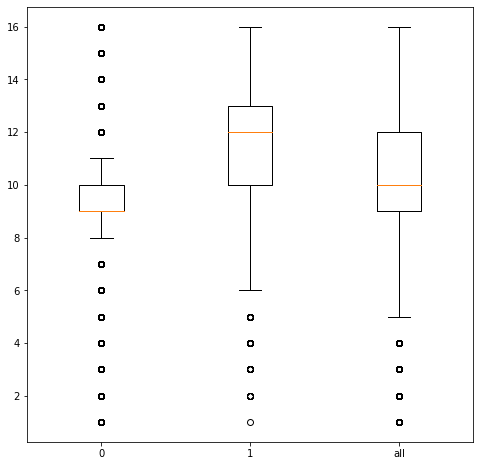

In [13]:
plt.figure(figsize=(8,8))
sns.histplot(x, x='education-num')
plt.show()

plt.figure(figsize=(8,8))
data = [x[x['label'] == 0]['education-num'], x[x['label'] == 1]['education-num'], x['education-num']]
plt.boxplot(data, labels=['0', '1', 'all'])
plt.show()

Ni outlier-i u koloni "education-num" nisu izbačeni jer su u realnim granicama.

Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64


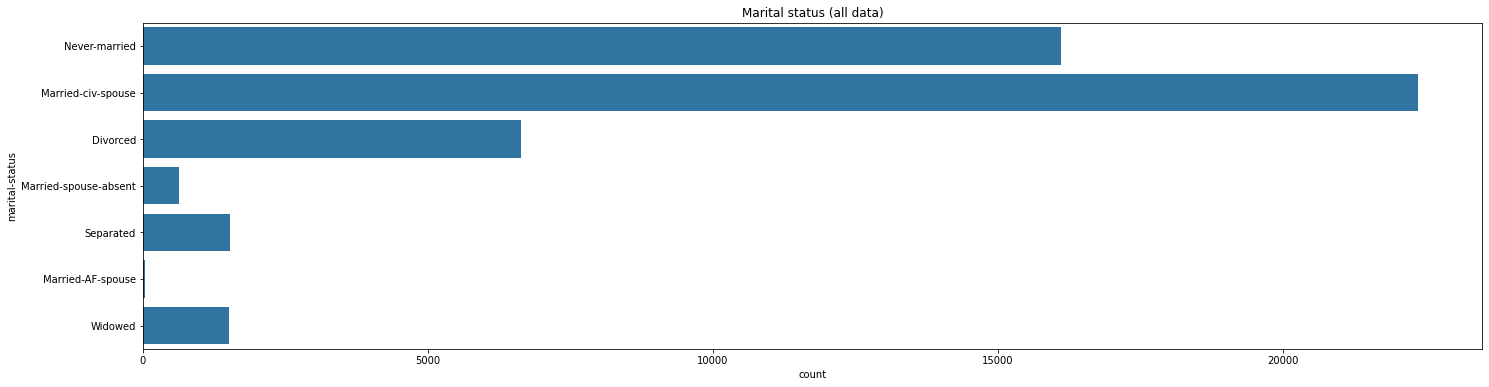

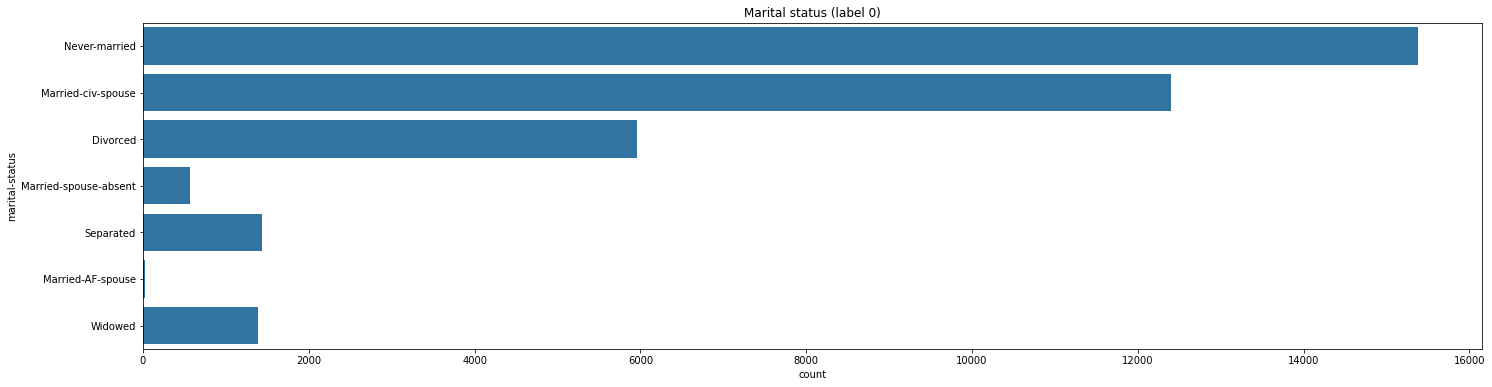

[Text(0.5, 1.0, 'Marital status (label 1)')]

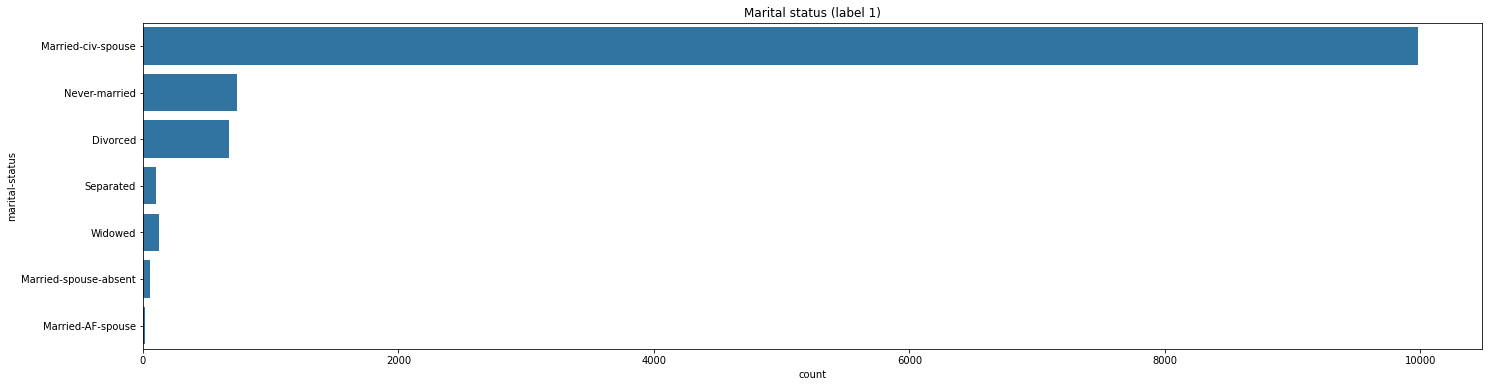

In [14]:
print(x['marital-status'].value_counts(dropna=False))
plt.figure(figsize=(24,6))
sns.countplot(x, y='marital-status').set(title='Marital status (all data)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 0], y='marital-status').set(title='Marital status (label 0)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 1], y='marital-status').set(title='Marital status (label 1)')

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Unknown              1843
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
NaN                   966
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64


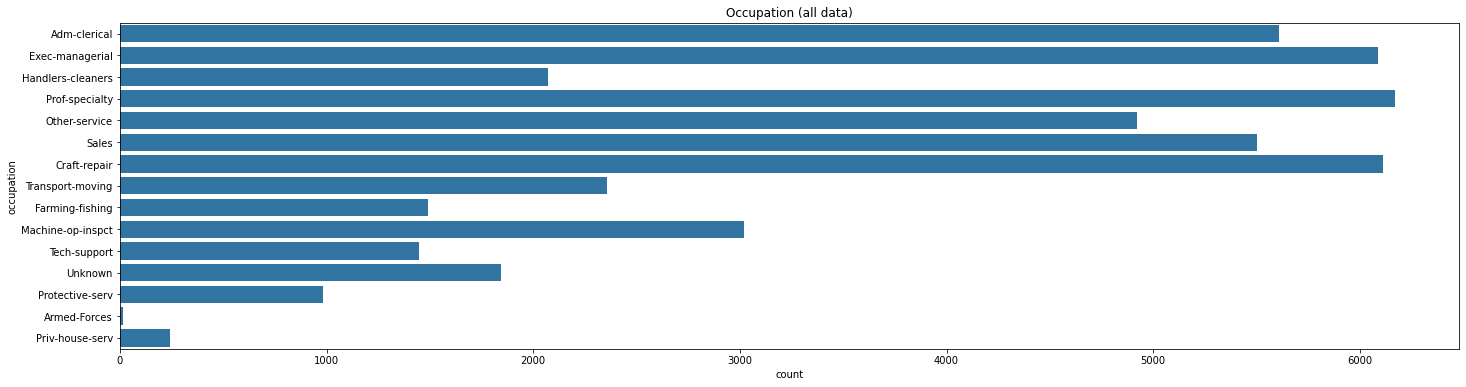

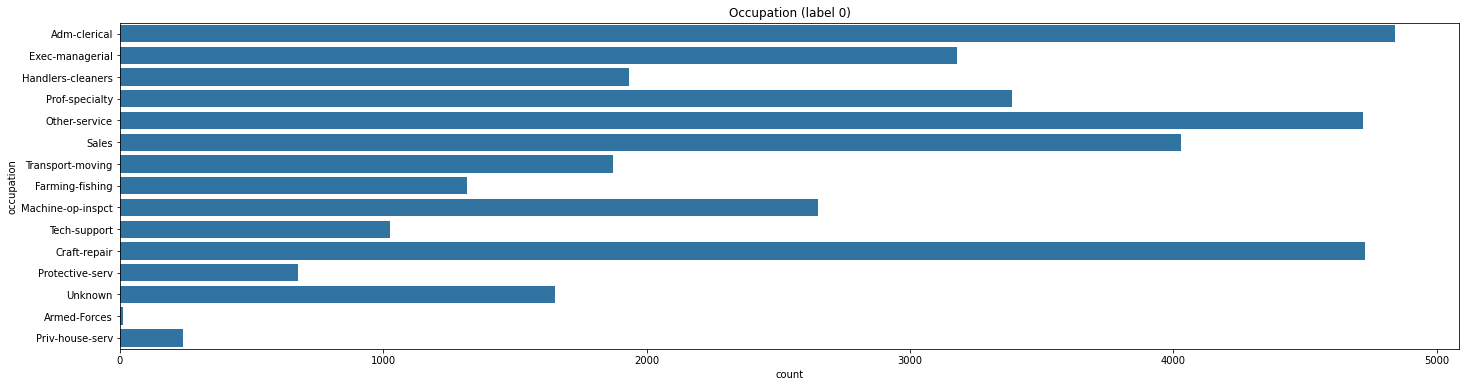

[Text(0.5, 1.0, 'Occupation (label 1)')]

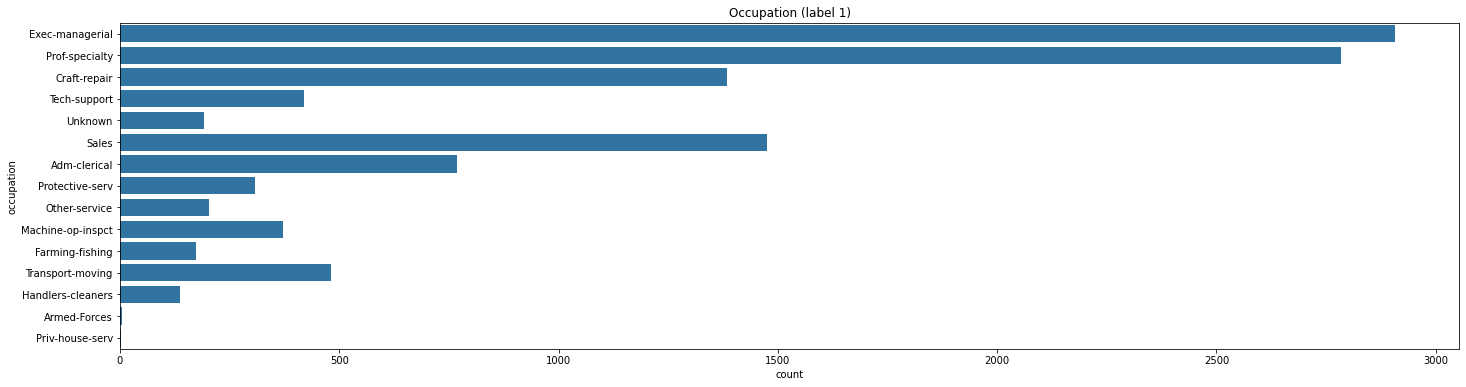

In [15]:
x['occupation'].replace('?', 'Unknown', inplace=True)
print(x['occupation'].value_counts(dropna=False))
plt.figure(figsize=(24,6))
sns.countplot(x, y='occupation').set(title='Occupation (all data)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 0], y='occupation').set(title='Occupation (label 0)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 1], y='occupation').set(title='Occupation (label 1)')

Husband           19716
Not-in-family     12583
Own-child          7581
Unmarried          5125
Wife               2331
Other-relative     1506
Name: relationship, dtype: int64


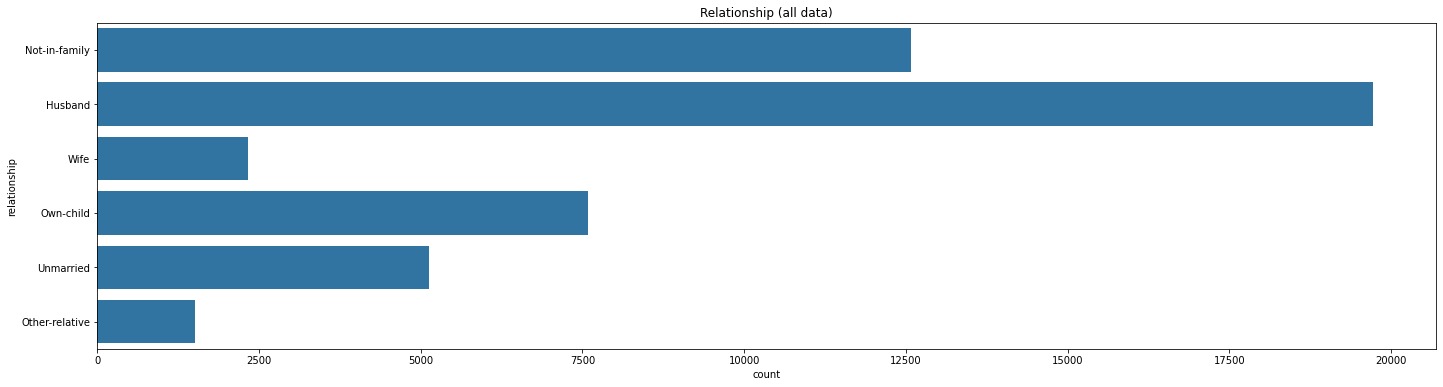

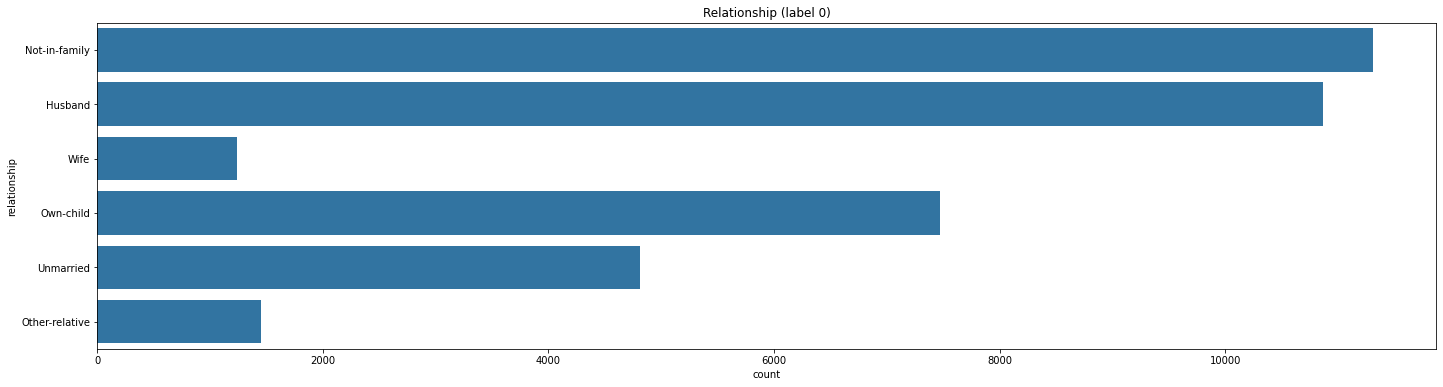

[Text(0.5, 1.0, 'Relationship (label 1)')]

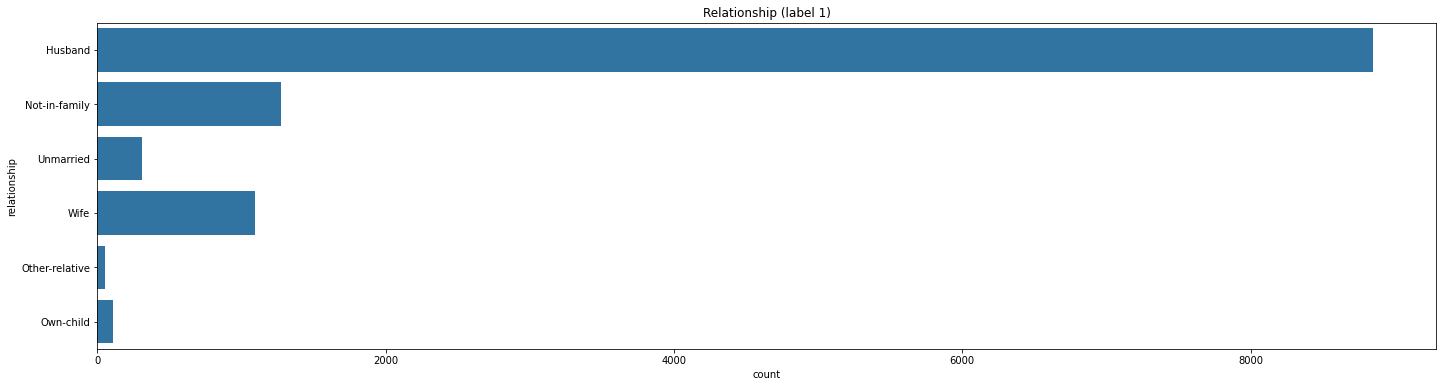

In [16]:
print(x['relationship'].value_counts(dropna=False))
plt.figure(figsize=(24,6))
sns.countplot(x, y='relationship').set(title='Relationship (all data)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 0], y='relationship').set(title='Relationship (label 0)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 1], y='relationship').set(title='Relationship (label 1)')

White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: race, dtype: int64


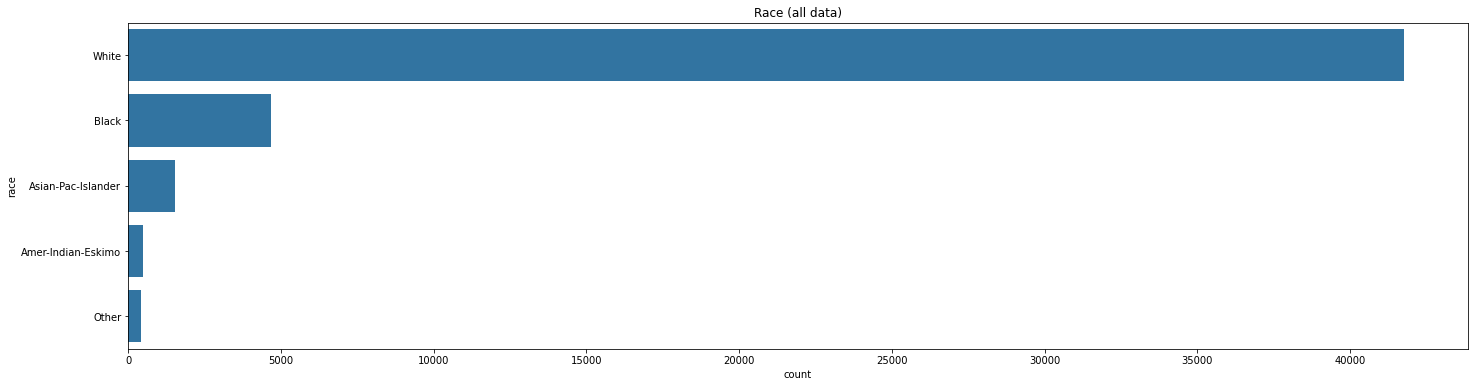

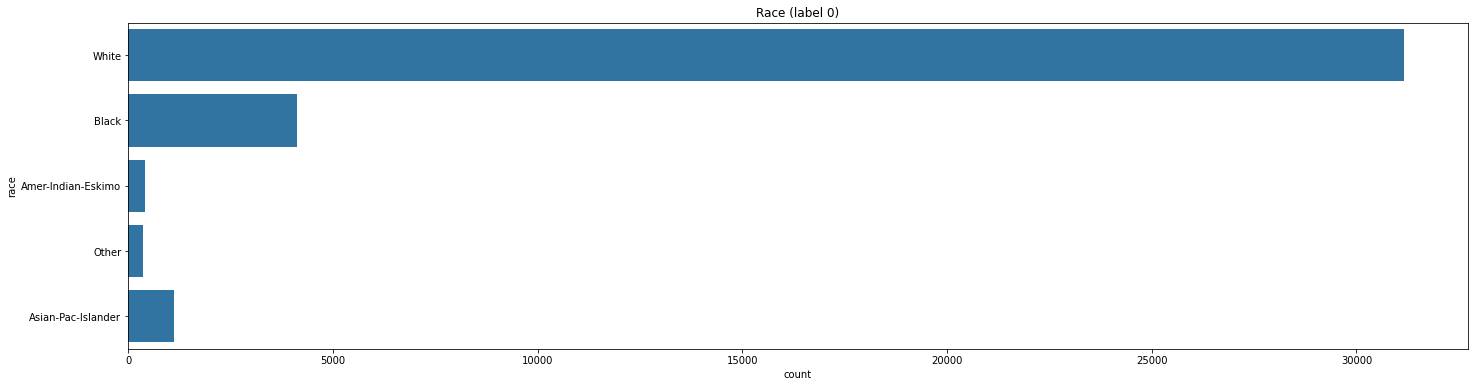

[Text(0.5, 1.0, 'Race (label 1)')]

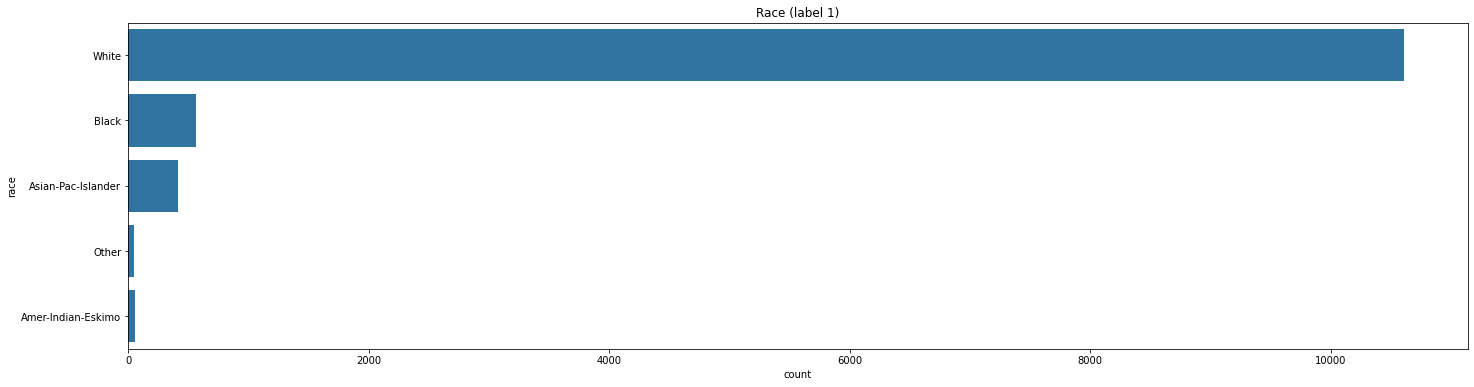

In [17]:
print(x['race'].value_counts(dropna=False))
plt.figure(figsize=(24,6))
sns.countplot(x, y='race').set(title='Race (all data)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 0], y='race').set(title='Race (label 0)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 1], y='race').set(title='Race (label 1)')

Male      32650
Female    16192
Name: sex, dtype: int64


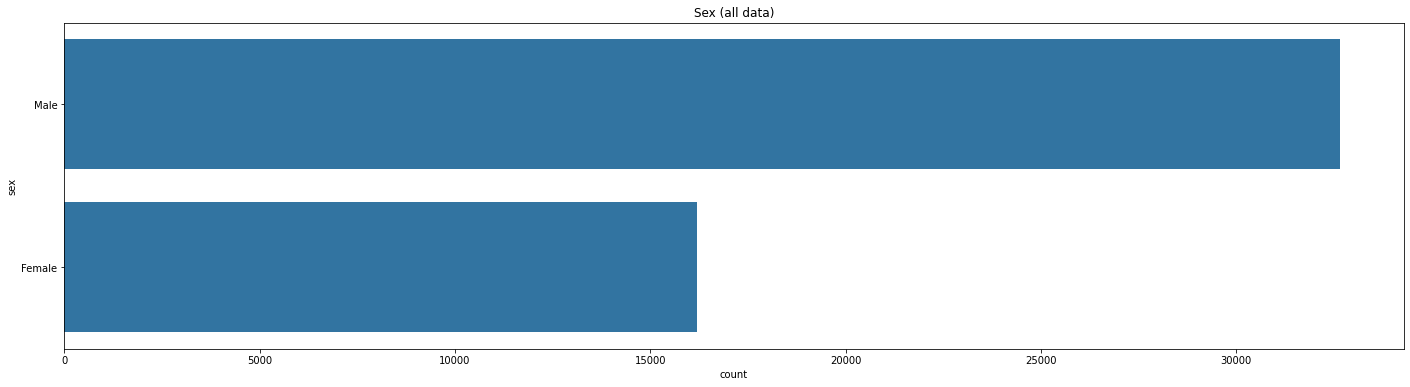

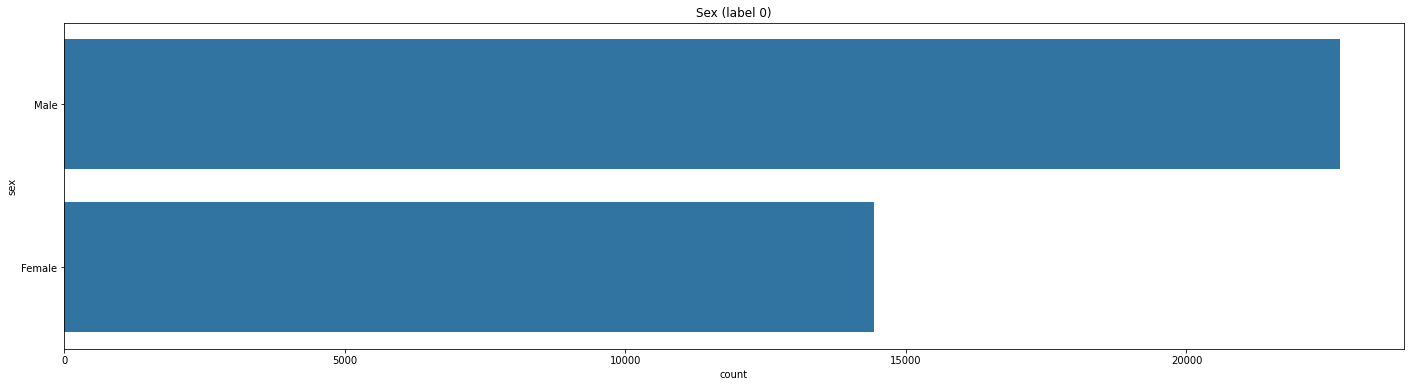

[Text(0.5, 1.0, 'Sex (label 1)')]

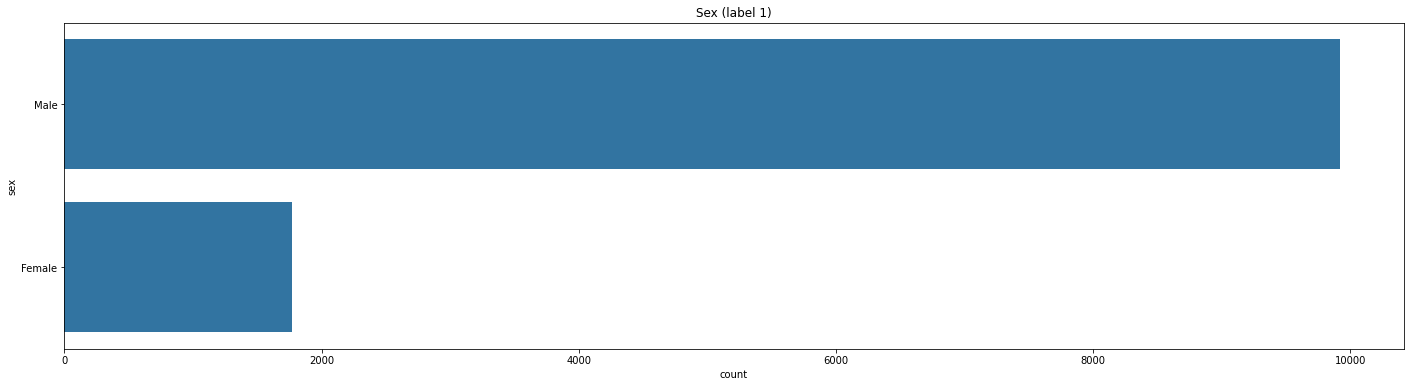

In [18]:
print(x['sex'].value_counts(dropna=False))
plt.figure(figsize=(24,6))
sns.countplot(x, y='sex').set(title='Sex (all data)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 0], y='sex').set(title='Sex (label 0)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 1], y='sex').set(title='Sex (label 1)')

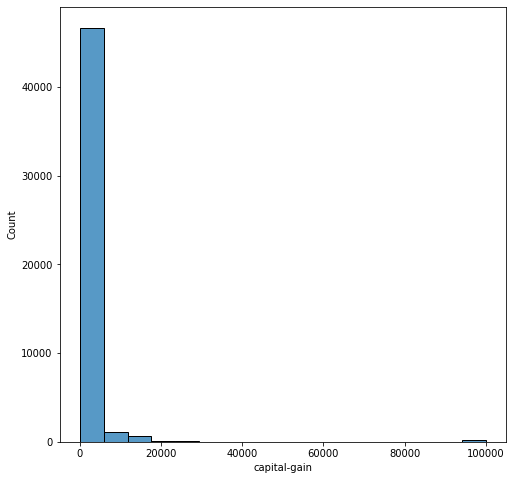

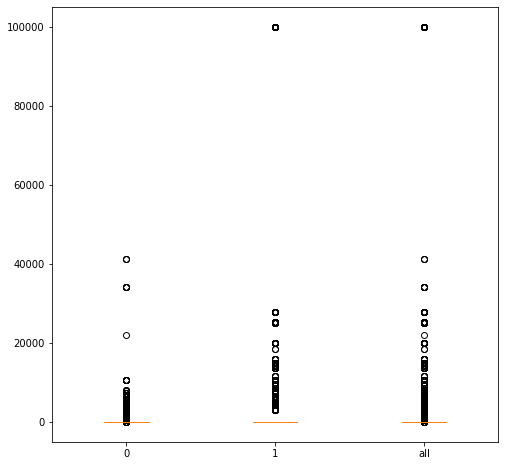

In [19]:
plt.figure(figsize=(8,8))
sns.histplot(x, x='capital-gain')
plt.show()

plt.figure(figsize=(8,8))
data = [x[x['label'] == 0]['capital-gain'], x[x['label'] == 1]['capital-gain'], x['capital-gain']]
plt.boxplot(data, labels=['0', '1', 'all'])
plt.show()

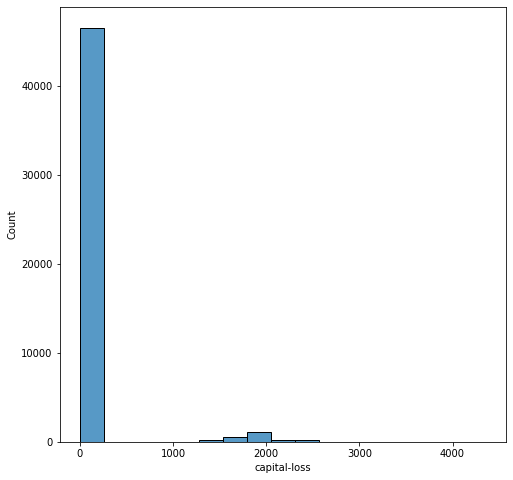

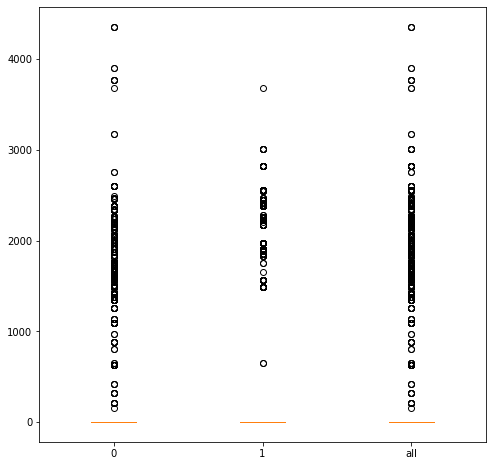

In [20]:
plt.figure(figsize=(8,8))
sns.histplot(x, x='capital-loss')
plt.show()

plt.figure(figsize=(8,8))
data = [x[x['label'] == 0]['capital-loss'], x[x['label'] == 1]['capital-loss'], x['capital-loss']]
plt.boxplot(data, labels=['0', '1', 'all'])
plt.show()

Kolone "capital-gain" i "capital-loss" kasnije su diskretizovane kako bi se smanjio uticaj outlier-a.

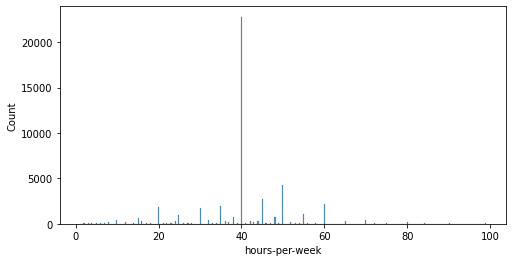

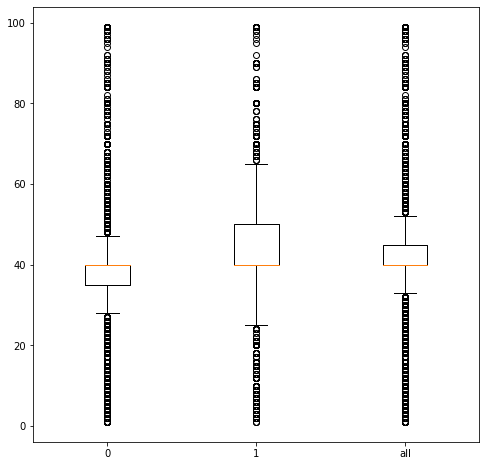

In [21]:
plt.figure(figsize=(8,4))
sns.histplot(x, x='hours-per-week')
plt.show()

plt.figure(figsize=(8,8))
data = [x[x['label'] == 0]['hours-per-week'], x[x['label'] == 1]['hours-per-week'], x['hours-per-week']]
plt.boxplot(data, labels=['0', '1', 'all'])
plt.show()

Outlier-i u koloni "hours-per-week" su u realnim granicama, a i njihovo izbacivanje negativno utiče na kasnije kreiranje modela.

United-States                 43832
Mexico                          951
Unknown                         583
Philippines                     295
NaN                             274
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                   

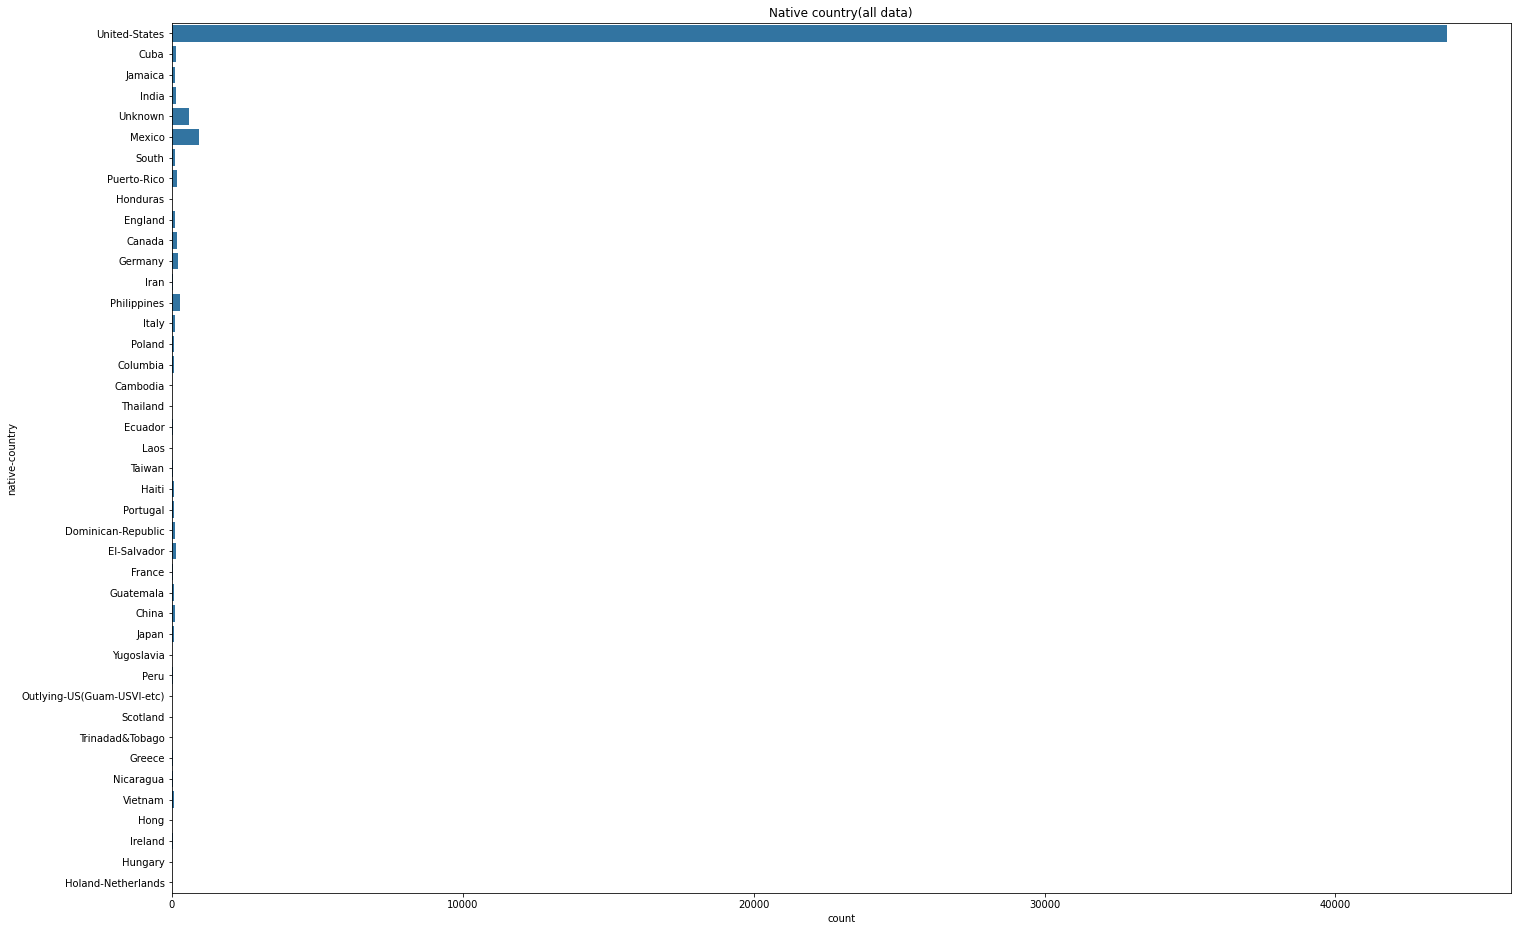

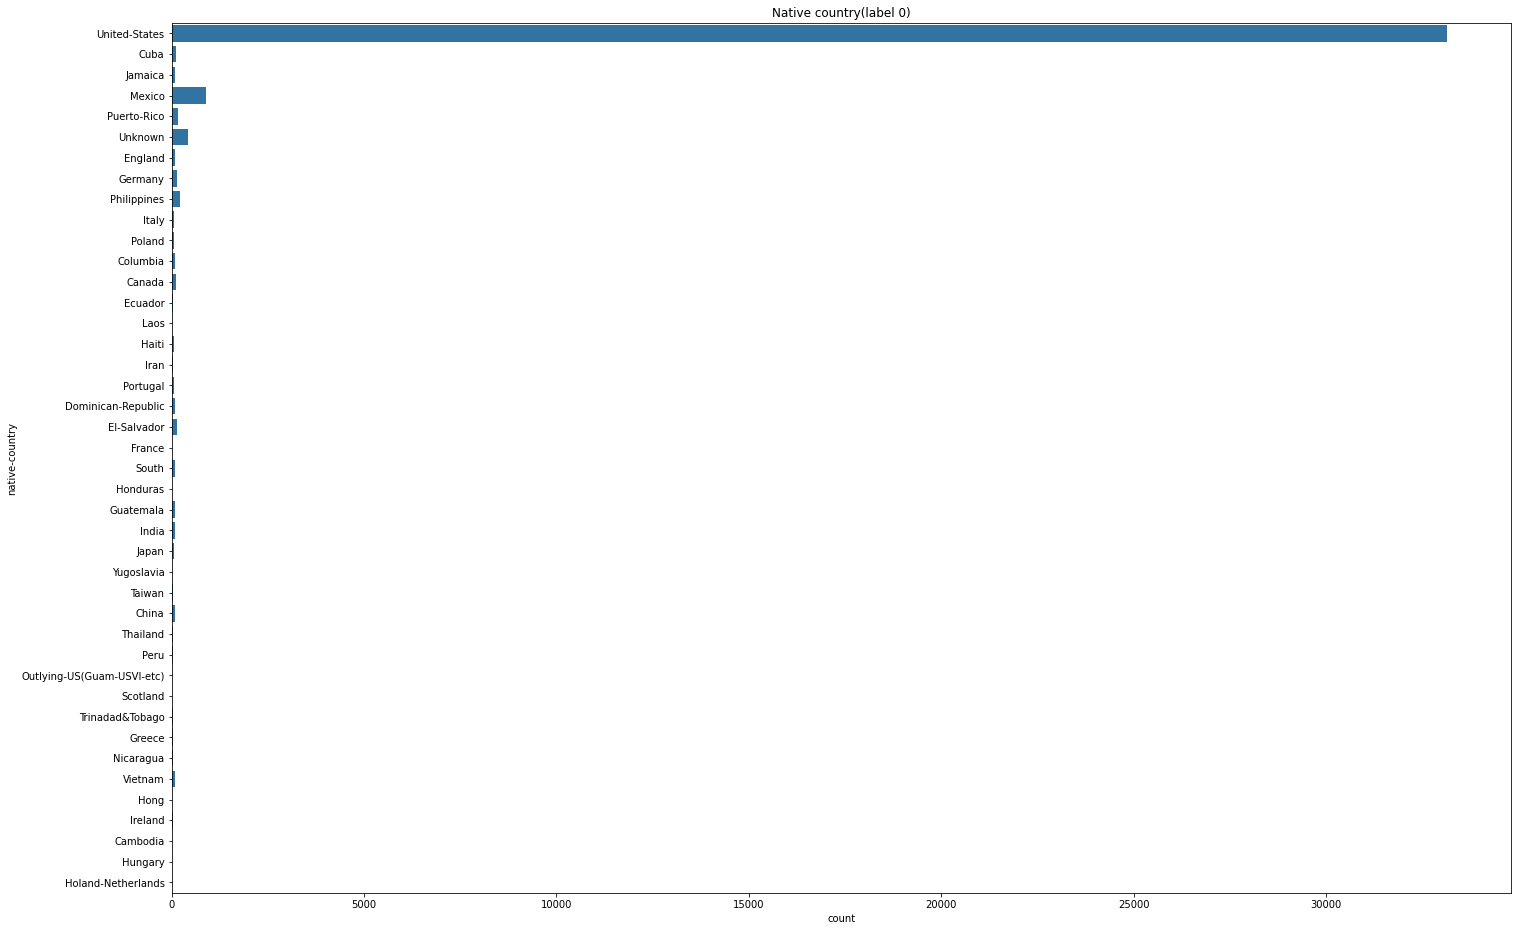

[Text(0.5, 1.0, 'Native country(label 1)')]

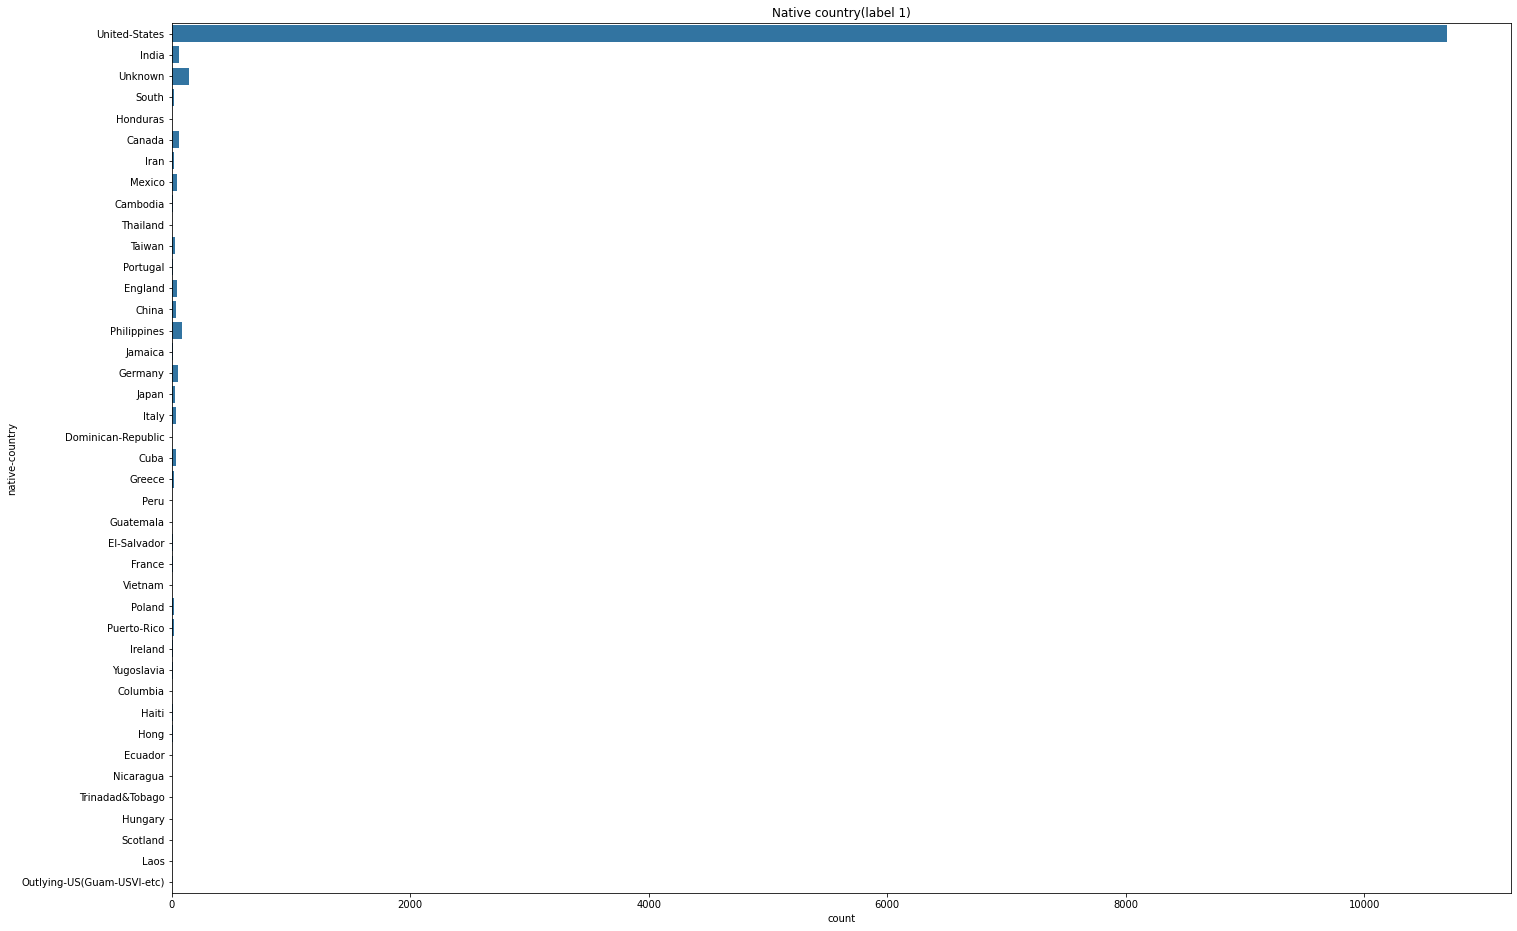

In [22]:
x['native-country'].replace('?', 'Unknown', inplace=True)
print(x['native-country'].value_counts(dropna=False))
plt.figure(figsize=(24,16))
sns.countplot(x, y='native-country').set(title='Native country(all data)')
plt.show()
plt.figure(figsize=(24,16))
sns.countplot(x[x['label'] == 0], y='native-country').set(title='Native country(label 0)')
plt.show()
plt.figure(figsize=(24,16))
sns.countplot(x[x['label'] == 1], y='native-country').set(title='Native country(label 1)')

Radi potencijalnog smanjenja broja feature-a pri kasnijoj analizi, izvršeno je grupisanje država na osnovu nekih sličnosti između njih.

United-States                 43832
Latin-America                  1864
Southeast-Asia                  830
EU                              609
Unknown                         583
NaN                             274
Carribes                        208
Canada                          182
UK                              148
South                           115
Japan                            92
Iran                             59
Yugoslavia                       23
Outlying-US(Guam-USVI-etc)       23
Name: native-country, dtype: int64


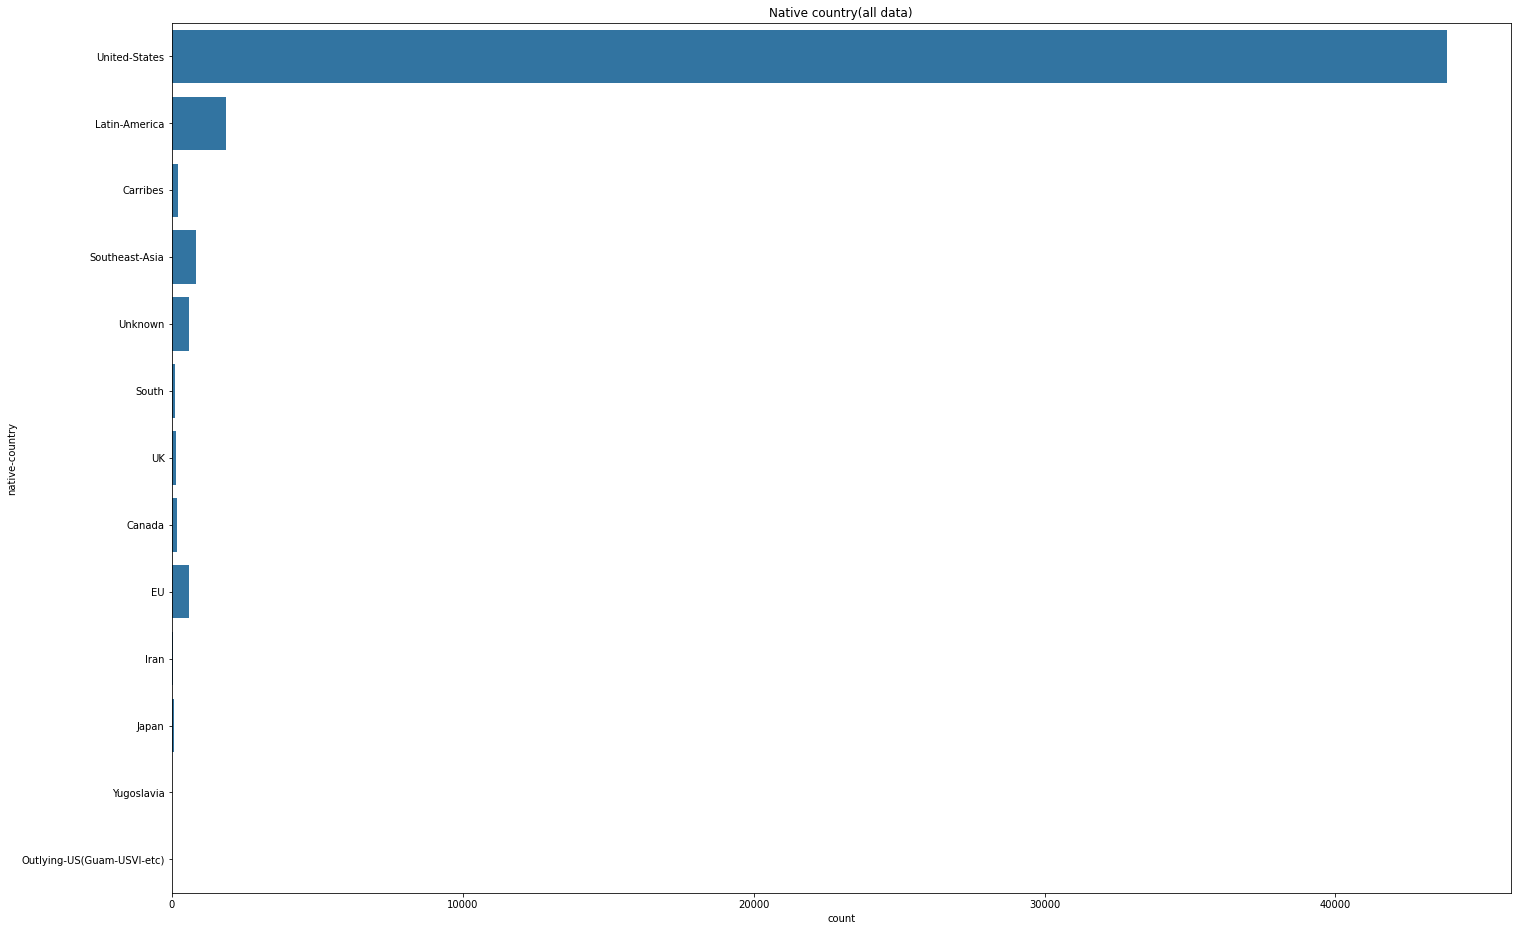

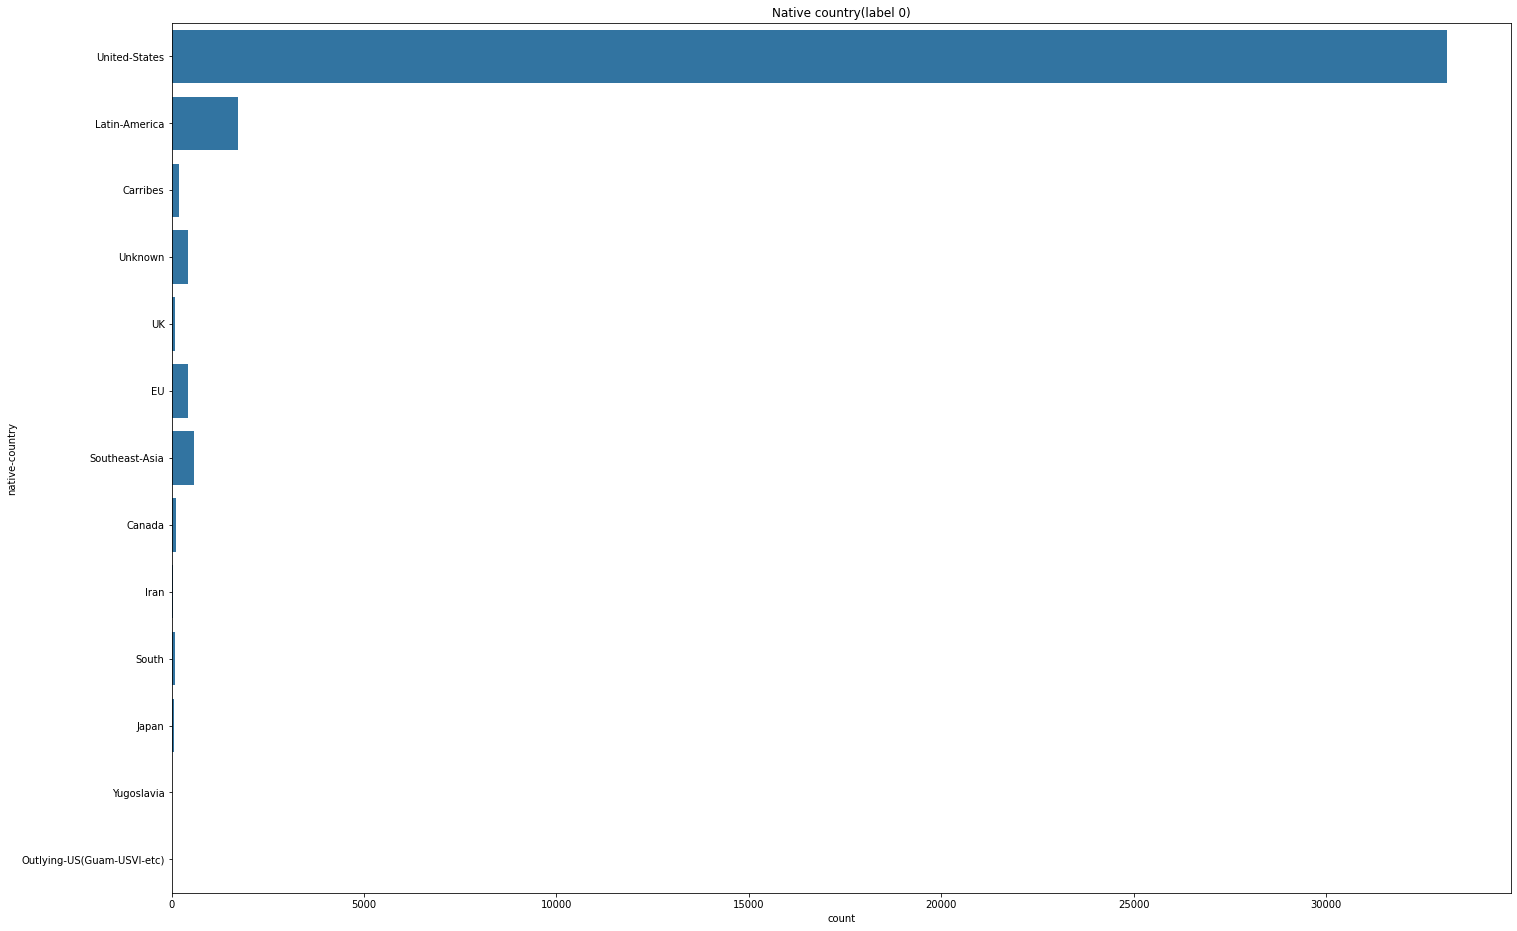

[Text(0.5, 1.0, 'Native country(label 1)')]

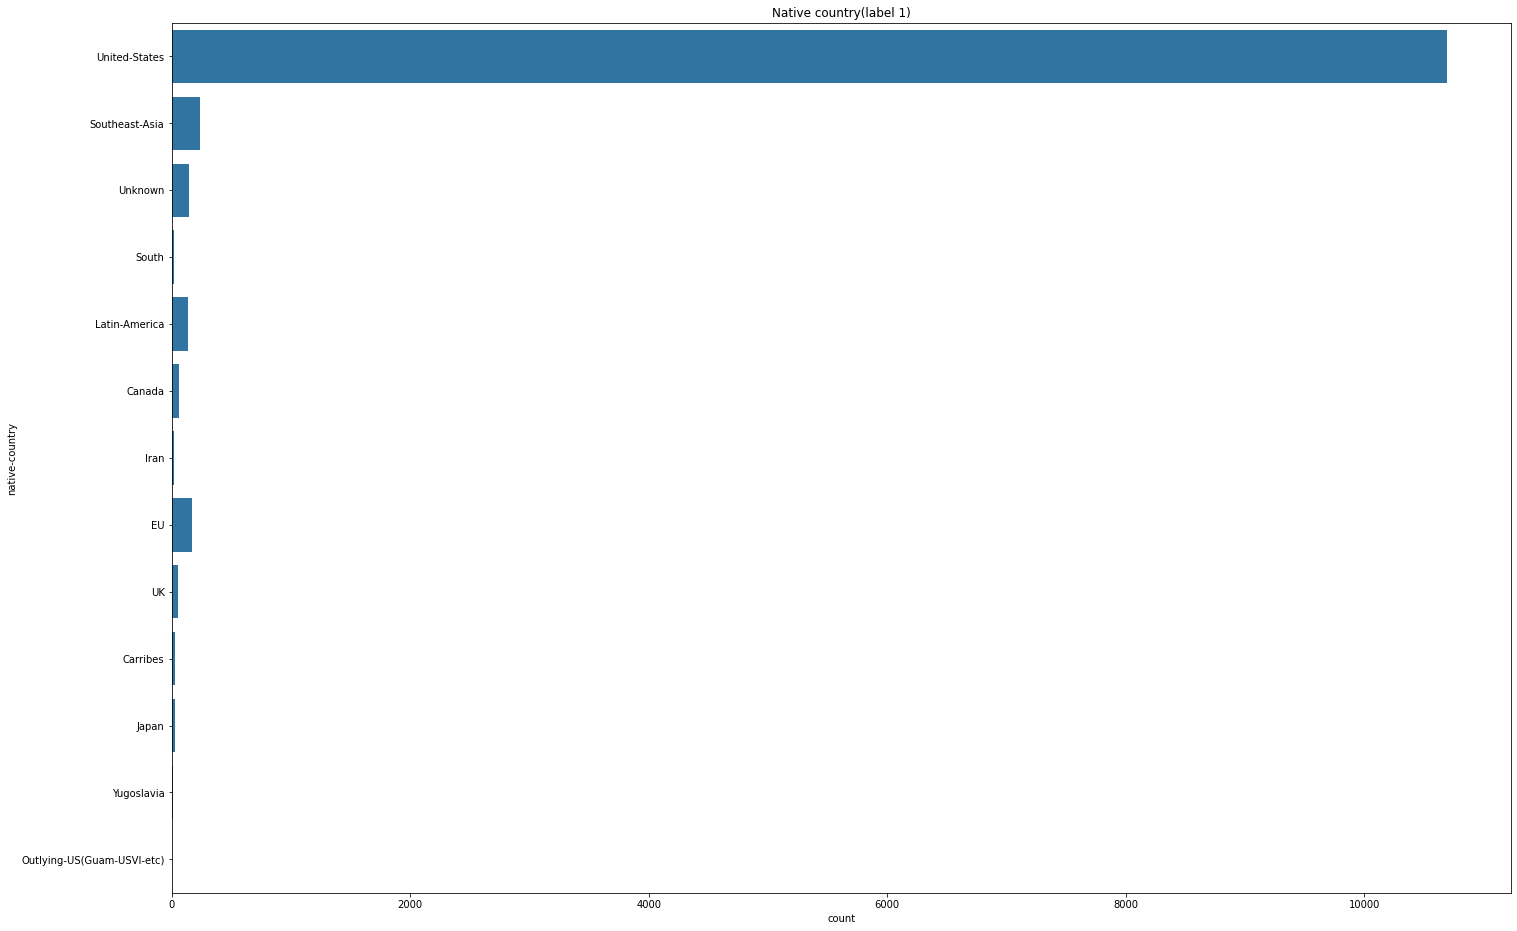

In [23]:
# Radi smanjenja broja kategorija, zemlje ce biti razvrstane u grupe.
eu_countries = ['Hungary', 'Ireland', 'Poland', 'France', 'Greece', 'Italy', 'Germany', 'Portugal', 'Holand-Netherlands']
uk_countries = ['England', 'Scotland']
carribean_countries = ['Haiti', 'Trinadad&Tobago', 'Jamaica']
southeast_asian_countries = ['India', 'Thailand', 'Taiwan', 'China', 'Philippines', 'Vietnam', 'Hong', 'Laos', 'Cambodia']
latin_american_countries = ['Honduras', 'Mexico', 'Dominican-Republic', 'Cuba', 'Peru', 'Guatemala', 'El-Salvador', 'Puerto-Rico', 'Columbia', 'Ecuador', 'Nicaragua']

x['native-country'] = x['native-country'].replace(eu_countries, 'EU')
x['native-country'] = x['native-country'].replace(uk_countries, 'UK')
x['native-country'] = x['native-country'].replace(carribean_countries, 'Carribes')
x['native-country'] = x['native-country'].replace(southeast_asian_countries, 'Southeast-Asia')
x['native-country'] = x['native-country'].replace(latin_american_countries, 'Latin-America')

print(x['native-country'].value_counts(dropna=False))
plt.figure(figsize=(24,16))
sns.countplot(x, y='native-country').set(title='Native country(all data)')
plt.show()
plt.figure(figsize=(24,16))
sns.countplot(x[x['label'] == 0], y='native-country').set(title='Native country(label 0)')
plt.show()
plt.figure(figsize=(24,16))
sns.countplot(x[x['label'] == 1], y='native-country').set(title='Native country(label 1)')

Sledeći korak predstavlja pripremu podataka za primenu Imputer-a koji će dopuniti nedostajuće vrednosti na osnovu postojećih podataka, i na taj način povećati količinu upotrebivih podataka.

In [24]:
# Za svaku kategoricku kolonu koja ima NaN vrednosti NaN se necim menja da bi mogao da se iskoristi LabelEncoder.
workclass_nas = x.loc[pd.isna(x['workclass']), :].index
occupation_nas = x.loc[pd.isna(x['occupation']), :].index
native_country_nas = x.loc[pd.isna(x['native-country']), :].index

x[x['workclass'].isna()].fillna('NA')
x[x['occupation'].isna()].fillna('NA')
x[x['native-country'].isna()].fillna('NA')

columns = x.columns

# Zatim se koristi Label Encoder nad kategorickim kolonama, da bi mogao da se upotrebi imputer.
label_encoder = preprocessing.LabelEncoder()

x['workclass'] = label_encoder.fit_transform(x['workclass'])
x['education'] = label_encoder.fit_transform(x['education'])
x['marital-status'] = label_encoder.fit_transform(x['marital-status'])
x['occupation'] = label_encoder.fit_transform(x['occupation'])
x['relationship'] = label_encoder.fit_transform(x['relationship'])
x['race'] = label_encoder.fit_transform(x['race'])
x['sex'] = label_encoder.fit_transform(x['sex'])
x['native-country'] = label_encoder.fit_transform(x['native-country'])

x['workclass'][workclass_nas] = pd.NA
x['occupation'][occupation_nas] = pd.NA
x['native-country'][native_country_nas] = pd.NA


In [25]:
print(x)
print(x.info())

       age  workclass  education  education-num  marital-status  occupation  \
0       39       6.00          9             13               4        0.00   
1       50       5.00          9             13               2        3.00   
2       38       3.00         11              9               0        5.00   
3       53       3.00          1              7               2        5.00   
4       28       3.00          9             13               2        9.00   
...    ...        ...        ...            ...             ...         ...   
48837   39       3.00          9             13               0        9.00   
48838   64        NaN         11              9               6         NaN   
48839   38       3.00          9             13               2        9.00   
48840   44       3.00          9             13               0        0.00   
48841   35       4.00          9             13               2        3.00   

       relationship  race  sex  capital-gain  capit

Nakon što su podaci pripremljeni, nad njima je primenjen Iterative Imputer za dopunu nedostajućih vrednosti.

In [26]:
# Koristimo Iterative Imputer da zamenimo NA vrednosti.
imputer = IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)
x_data = imputer.fit_transform(x)

In [27]:
for i in range(x_data.shape[1]):
    x[columns[i]] = x_data[:, i].astype(np.int32)
    
print(x)

       age  workclass  education  education-num  marital-status  occupation  \
0       39          6          9             13               4           0   
1       50          5          9             13               2           3   
2       38          3         11              9               0           5   
3       53          3          1              7               2           5   
4       28          3          9             13               2           9   
...    ...        ...        ...            ...             ...         ...   
48837   39          3          9             13               0           9   
48838   64          3         11              9               6           6   
48839   38          3          9             13               2           9   
48840   44          3          9             13               0           0   
48841   35          4          9             13               2           3   

       relationship  race  sex  capital-gain  capit

In [28]:
print(x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             48842 non-null  int32
 1   workclass       48842 non-null  int32
 2   education       48842 non-null  int32
 3   education-num   48842 non-null  int32
 4   marital-status  48842 non-null  int32
 5   occupation      48842 non-null  int32
 6   relationship    48842 non-null  int32
 7   race            48842 non-null  int32
 8   sex             48842 non-null  int32
 9   capital-gain    48842 non-null  int32
 10  capital-loss    48842 non-null  int32
 11  hours-per-week  48842 non-null  int32
 12  native-country  48842 non-null  int32
 13  label           48842 non-null  int32
dtypes: int32(14)
memory usage: 2.6 MB
None


Nakon toga, izvršena je gore pomenuta diskretizacija kolona "capital-gain" i "capital-loss".

In [29]:
# Diskretizacija 'capital-gain' kolone.
x['capital-gain'] = x['capital-gain'].apply(lambda y: 'No-gain' if y<500 else 'Some-gain')

No-gain      44820
Some-gain     4022
Name: capital-gain, dtype: int64


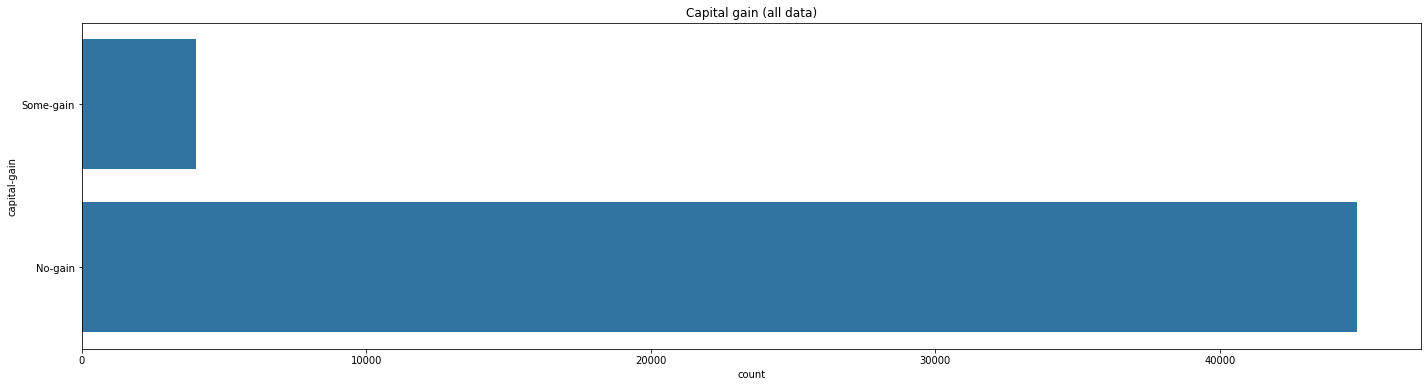

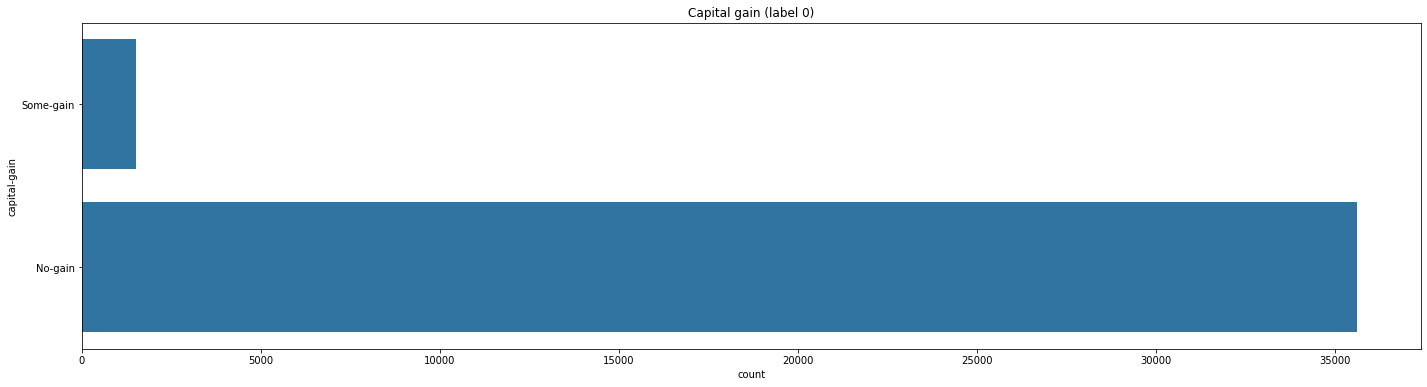

[Text(0.5, 1.0, 'Capital gain (label 1)')]

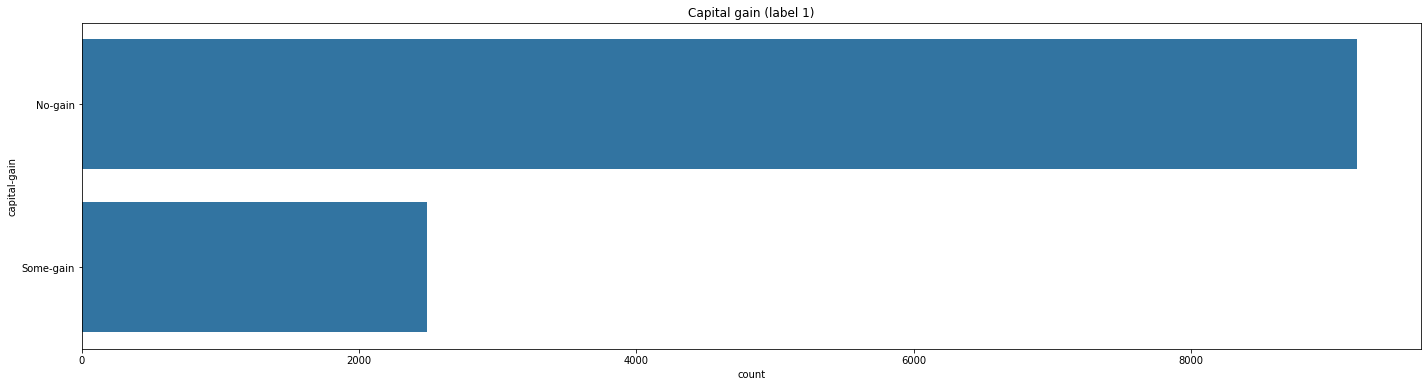

In [30]:
# Novi 'capital-gain'.
print(x['capital-gain'].value_counts(dropna=False))
plt.figure(figsize=(24,6))
sns.countplot(x, y='capital-gain').set(title='Capital gain (all data)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 0], y='capital-gain').set(title='Capital gain (label 0)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 1], y='capital-gain').set(title='Capital gain (label 1)')

In [31]:
# Diskretizacija 'capital-loss' kolone.
x['capital-loss'] = x['capital-loss'].apply(lambda y: 'No-loss' if y<500 else 'Some-loss')

No-loss      46574
Some-loss     2268
Name: capital-loss, dtype: int64


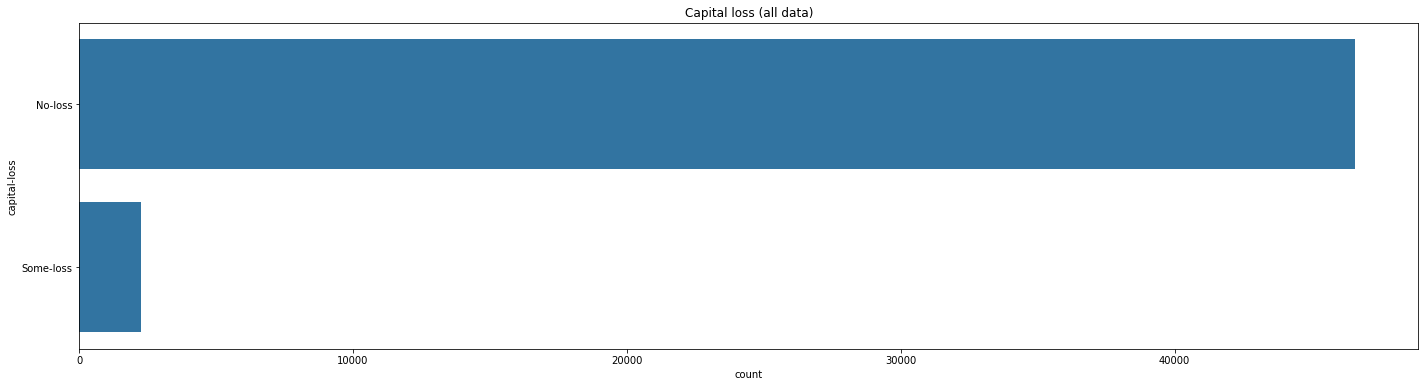

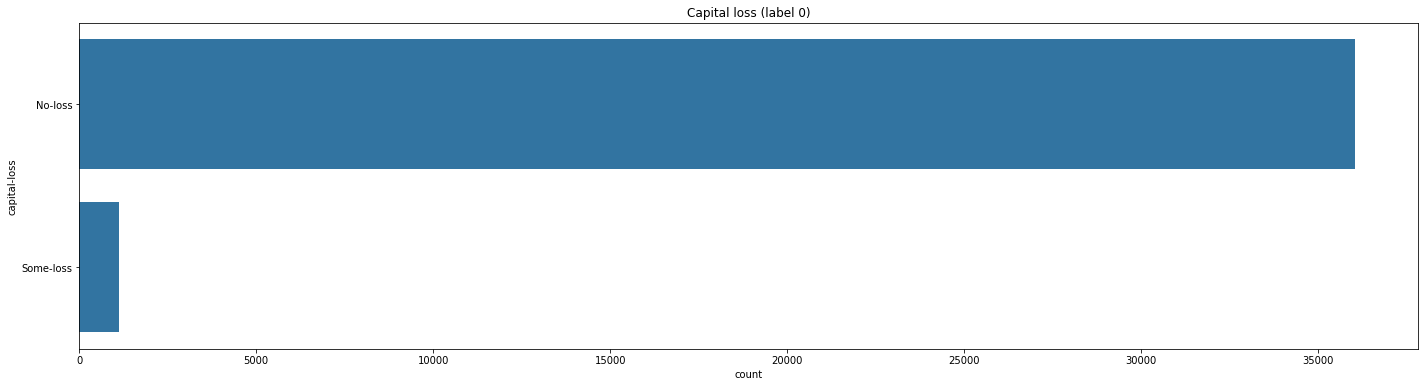

[Text(0.5, 1.0, 'Capital loss (label 1)')]

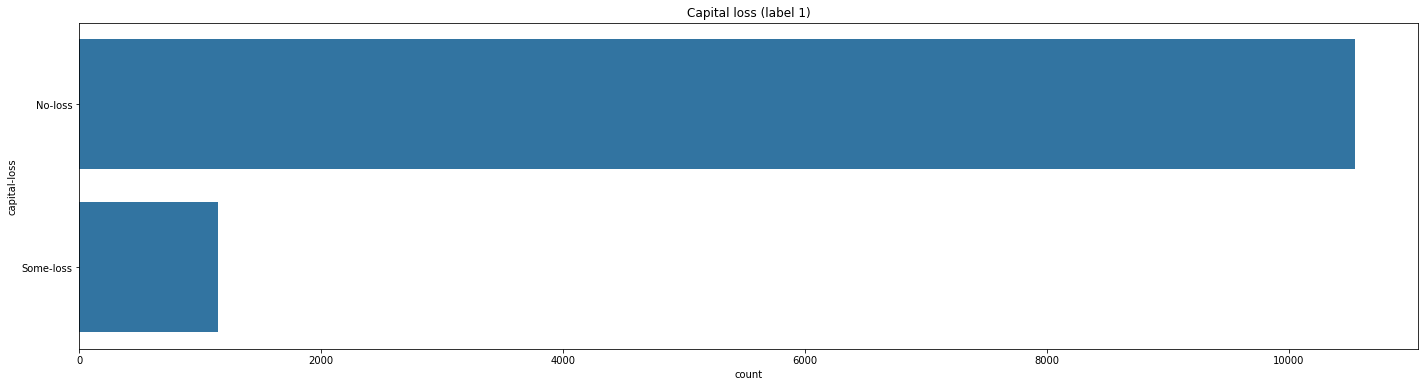

In [32]:
# Novi 'capital-loss'.
print(x['capital-loss'].value_counts(dropna=False))
plt.figure(figsize=(24,6))
sns.countplot(x, y='capital-loss').set(title='Capital loss (all data)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 0], y='capital-loss').set(title='Capital loss (label 0)')
plt.show()
plt.figure(figsize=(24,6))
sns.countplot(x[x['label'] == 1], y='capital-loss').set(title='Capital loss (label 1)')

In [33]:
# Filtiranje duplikata.
x = x.drop_duplicates()
print(x.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42087 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             42087 non-null  int32 
 1   workclass       42087 non-null  int32 
 2   education       42087 non-null  int32 
 3   education-num   42087 non-null  int32 
 4   marital-status  42087 non-null  int32 
 5   occupation      42087 non-null  int32 
 6   relationship    42087 non-null  int32 
 7   race            42087 non-null  int32 
 8   sex             42087 non-null  int32 
 9   capital-gain    42087 non-null  object
 10  capital-loss    42087 non-null  object
 11  hours-per-week  42087 non-null  int32 
 12  native-country  42087 non-null  int32 
 13  label           42087 non-null  int32 
dtypes: int32(12), object(2)
memory usage: 2.9+ MB
None


In [34]:
x['capital-gain'][x['capital-gain'] == 'No-gain'] = 0
x['capital-gain'][x['capital-gain'] == 'Some-gain'] = 1

x['capital-loss'][x['capital-loss'] == 'No-loss'] = 0
x['capital-loss'][x['capital-loss'] == 'Some-loss'] = 1

# Kreiranje trening i test seta

In [35]:
# Razdvajanje podataka na trening i test podatke.
labels = x['label'].to_numpy()
x = x.drop(['label'], axis=1)

train_x, test_x, train_y, test_y = train_test_split(x, labels, test_size=0.25, shuffle=True)

In [36]:
train_x['age'] = train_x['age'].astype(np.float64)
train_x['education-num'] = train_x['education-num'].astype(np.float64)
train_x['hours-per-week'] = train_x['hours-per-week'].astype(np.float64)

test_x['age'] = test_x['age'].astype(np.float64)
test_x['education-num'] = test_x['education-num'].astype(np.float64)
test_x['hours-per-week'] = test_x['hours-per-week'].astype(np.float64)

# Selekcija feature-a od značaja

Ovde je ostavljen zakomentarisan kod kojim je bila isprobana Lasso regresija za selekciju feature-a. Međutim, ovakva selekcija feature-a značajno je pogoršala accuracy-e kasnije kreiranih modela (8-10%, u zavisnosti od modela), zbog čega je ipak iskorišćen Random Forest classifier.

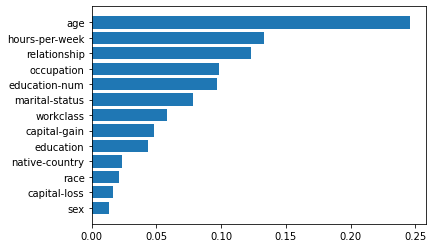

['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']


In [37]:
# Provera koji su atributi znacajni koriscenjem Random Forest Classifier-a.
selector = SelectFromModel(RandomForestClassifier(random_state=42, n_estimators=100))
selector.fit(train_x, train_y)

feature_importances = list(zip(train_x.columns, selector.estimator_.feature_importances_))
feature_importances.sort(key = lambda x: x[1])
plt.barh([x[0] for x in feature_importances],[x[1] for x in feature_importances])

plt.show()

selected = selector.get_support()
selected_features =  list(train_x.columns[(selected)])
print(selected_features)

In [217]:
# Pronalazenje najboljih parametara za Lasso regresiju.
# lasso_params = {"alpha":np.arange(0.00001, 10, 500)}
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# lasso_regresor = Lasso()
# lasso_grid_cv=GridSearchCV(lasso_regresor, param_grid=lasso_params, cv=cv)
# lasso_grid_cv.fit(train_x, train_y)
# print(lasso_grid_cv.best_params_)

{'alpha': 1e-05}


In [218]:
# lasso_optimized_params = {'alpha': 1e-05}

[('marital-status', -0.023503601074884656), ('relationship', -0.015130710538300916), ('workclass', -0.01095554452114491), ('education', -0.002892759929082869), ('native-country', -0.0026746682423747143), ('occupation', 0.0008410246426456829), ('hours-per-week', 0.0035198919655821718), ('age', 0.0040681253765498275), ('race', 0.014644591519053927), ('education-num', 0.04497782159845593), ('sex', 0.09632185603654686), ('capital-loss', 0.21221303960923113), ('capital-gain', 0.30632984249534345)]


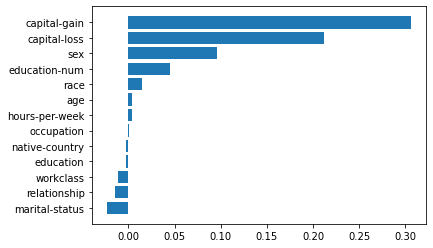

In [219]:
# Koriscenje Lasso regresije za izdvajanje znacajnih kolona.
# lasso_selector = Lasso(**lasso_optimized_params)
# lasso_selector.fit(train_x, train_y)

# feature_importances = list(zip(train_x.columns, lasso_selector.coef_))
# feature_importances.sort(key = lambda x: x[1])
# plt.barh([x[0] for x in feature_importances],[x[1] for x in feature_importances])

# print(feature_importances)

In [220]:
# Selektovacemo top 5 feature-a.
# selected_features = feature_importances[-5:]
# selected_features = [pair[0] for pair in selected_features]
# print(selected_features)

['race', 'education-num', 'sex', 'capital-loss', 'capital-gain']


Na osnovu dobijenih rezultata selektuju se kolone od značaja.

In [38]:
# Filtriranje kolona od znacaja.
train_x = train_x[selected_features]
test_x = test_x[selected_features]

print(train_x)
print(test_x)

        age  education-num  marital-status  occupation  relationship  \
16557 31.00          13.00               2           0             5   
21629 25.00          10.00               0           9             4   
6848  63.00           9.00               2           2             0   
6421  30.00          15.00               2           9             0   
20465 39.00          15.00               2           9             0   
...     ...            ...             ...         ...           ...   
26603 36.00           9.00               2           6             0   
26249 66.00          13.00               2          11             0   
12385 34.00          13.00               2          10             0   
37410 35.00          13.00               2           9             5   
2820  32.00          13.00               2           3             0   

       hours-per-week  
16557           40.00  
21629           35.00  
6848            48.00  
6421            40.00  
20465          

Za preostale kategoričke kolone će, zbog velikog broja mogućih vrednosti, biti primenjen Binary Encoder, jer bi primena One-Hot Encoder-a rezultirara ogromnim povećanjem dimenzionalnosti podataka. 
Preostali zakomentarisani kod bio je korišćen kada se za selekciju feature-a koristila Lasso regresija. Pošto je tada u opticaju ostala samo jedna kategorička kolona, i to sa malim brojem vrednosti, bio je primenjen One-Hot enkoder.

In [39]:
# Za sve kolone koje imaju kategoricke vrednosti koristi se binary encoder.
binary_encoder = ce.BinaryEncoder(cols=['marital-status', 'occupation', 'relationship'], drop_invariant = True)
binary_encoder.fit(train_x)
train_x = binary_encoder.transform(train_x)
test_x = binary_encoder.transform(test_x)

# one_hot_encoder = preprocessing.OneHotEncoder(sparse=False, handle_unknown='infrequent_if_exist')
# train_x_race = pd.DataFrame(np.array(train_x['race']).reshape((-1, 1)), columns=['race', ])
# test_x_race = pd.DataFrame(np.array(test_x['race']).reshape((-1, 1)), columns=['race', ])
# one_hot_encoder.fit(train_x_race)
# train_x_race = one_hot_encoder.transform(train_x_race)
# test_x_race = one_hot_encoder.transform(test_x_race)

# for i in range(train_x_race.shape[-1]):
#     train_x['race_' + str(i)] = train_x_race[:, i]
#     test_x['race_' + str(i)] = test_x_race[:, i]

# train_x = train_x.drop('race', axis=1)
# test_x =test_x.drop('race', axis=1)
    
print(train_x)
print(test_x)

        age  education-num  marital-status_0  marital-status_1  \
16557 31.00          13.00                 0                 0   
21629 25.00          10.00                 0                 1   
6848  63.00           9.00                 0                 0   
6421  30.00          15.00                 0                 0   
20465 39.00          15.00                 0                 0   
...     ...            ...               ...               ...   
26603 36.00           9.00                 0                 0   
26249 66.00          13.00                 0                 0   
12385 34.00          13.00                 0                 0   
37410 35.00          13.00                 0                 0   
2820  32.00          13.00                 0                 0   

       marital-status_2  occupation_0  occupation_1  occupation_2  \
16557                 1             0             0             0   
21629                 0             0             0             1   


Kao poslednji korak u predobradi podataka, podaci su normalizovani na opseg 0-1.

In [40]:
# Normalizacija podataka.
train_x = (train_x - train_x.min()) / (train_x.max() - train_x.min())
test_x = (test_x - test_x.min()) / (test_x.max() - test_x.min())

print(train_x)
print(test_x)

       age  education-num  marital-status_0  marital-status_1  \
16557 0.19           0.80              0.00              0.00   
21629 0.11           0.60              0.00              1.00   
6848  0.63           0.53              0.00              0.00   
6421  0.18           0.93              0.00              0.00   
20465 0.30           0.93              0.00              0.00   
...    ...            ...               ...               ...   
26603 0.26           0.53              0.00              0.00   
26249 0.67           0.80              0.00              0.00   
12385 0.23           0.80              0.00              0.00   
37410 0.25           0.80              0.00              0.00   
2820  0.21           0.80              0.00              0.00   

       marital-status_2  occupation_0  occupation_1  occupation_2  \
16557              1.00          0.00          0.00          0.00   
21629              0.00          0.00          0.00          1.00   
6848        

## Provera koji modeli su potencijalno dobri za primenu nad izabranim podacima

In [41]:
# Provera koji modeli su dobri za koriscenje.
lazy_classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_classifier.fit(train_x, test_x, train_y, test_y)
print(models)

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28/29 [03:03<00:07,  7.49s/it]

[LightGBM] [Info] Number of positive: 7771, number of negative: 23794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 31565, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.246190 -> initscore=-1.119035
[LightGBM] [Info] Start training from score -1.119035


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [03:04<00:00,  6.35s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
QuadraticDiscriminantAnalysis      0.75               0.77     0.77      0.76   
NearestCentroid                    0.72               0.76     0.76      0.74   
GaussianNB                         0.72               0.75     0.75      0.74   
BernoulliNB                        0.74               0.75     0.75      0.76   
LGBMClassifier                     0.83               0.74     0.74      0.83   
XGBClassifier                      0.83               0.74     0.74      0.82   
SGDClassifier                      0.81               0.72     0.72      0.81   
SVC                                0.82               0.72     0.72      0.82   
KNeighborsClassifier               0.81               0.72     0.72      0.80   
AdaBoostClassifier                 0.82               0.72     0.72      0.82   
PassiveAggressiveClassifier 

## Balansiranje trening seta

In [42]:
# Balansiranje trening podataka.
print("Stari broj trening podataka:", np.sum(train_y==0), np.sum(train_y==1))

# oversampler = RandomOverSampler(random_state=42)
# train_x, train_y = oversampler.fit_resample(train_x, train_y)

oversampler = SMOTE()
train_x, train_y = oversampler.fit_resample(train_x, train_y)

print("Novi broj trening podataka:", np.sum(train_y==0), np.sum(train_y==1))

Stari broj trening podataka: 23794 7771
Novi broj trening podataka: 23794 23794


In [43]:
print(train_x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47588 entries, 0 to 47587
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               47588 non-null  float64
 1   education-num     47588 non-null  float64
 2   marital-status_0  47588 non-null  float64
 3   marital-status_1  47588 non-null  float64
 4   marital-status_2  47588 non-null  float64
 5   occupation_0      47588 non-null  float64
 6   occupation_1      47588 non-null  float64
 7   occupation_2      47588 non-null  float64
 8   occupation_3      47588 non-null  float64
 9   relationship_0    47588 non-null  float64
 10  relationship_1    47588 non-null  float64
 11  relationship_2    47588 non-null  float64
 12  hours-per-week    47588 non-null  float64
dtypes: float64(13)
memory usage: 4.7 MB
None


SMOTE sve konvertuje u float, pa su sledećom ćelijom samo vraćeni stari tipovi podataka. Zakomentarisani kod je iz testa sa Lasso regresijom.

In [44]:
# Konvertovanje tipova kolona u koji su naruseni.

train_x['marital-status_0'] = train_x['marital-status_0'].astype(np.uint8)
test_x['marital-status_0'] = test_x['marital-status_0'].astype(np.uint8)

train_x['marital-status_1'] = train_x['marital-status_1'].astype(np.uint8)
test_x['marital-status_1'] = test_x['marital-status_1'].astype(np.uint8)

train_x['marital-status_2'] = train_x['marital-status_2'].astype(np.uint8)
test_x['marital-status_2'] = test_x['marital-status_2'].astype(np.uint8)

train_x['occupation_0'] = train_x['occupation_0'].astype(np.uint8)
test_x['occupation_0'] = test_x['occupation_0'].astype(np.uint8)

train_x['occupation_1'] = train_x['occupation_1'].astype(np.uint8)
test_x['occupation_1'] = test_x['occupation_1'].astype(np.uint8)

train_x['occupation_2'] = train_x['occupation_2'].astype(np.uint8)
test_x['occupation_2'] = test_x['occupation_2'].astype(np.uint8)

train_x['occupation_3'] = train_x['occupation_3'].astype(np.uint8)
test_x['occupation_3'] = test_x['occupation_3'].astype(np.uint8)

train_x['relationship_0'] = train_x['relationship_0'].astype(np.uint8)
test_x['relationship_0'] = test_x['relationship_0'].astype(np.uint8)

train_x['relationship_1'] = train_x['relationship_1'].astype(np.uint8)
test_x['relationship_1'] = test_x['relationship_1'].astype(np.uint8)

train_x['relationship_2'] = train_x['relationship_2'].astype(np.uint8)
test_x['relationship_2'] = test_x['relationship_2'].astype(np.uint8)

# train_x['education-num'] = train_x['education-num'].astype(np.float64)
# test_x['education-num'] = test_x['education-num'].astype(np.float64)

# train_x['sex'] = train_x['sex'].astype(np.int32)
# test_x['sex'] = test_x['sex'].astype(np.int32)

# train_x['capital-loss'] = train_x['capital-loss'].astype(np.uint8)
# test_x['capital-loss'] = test_x['capital-loss'].astype(np.uint8)

# train_x['capital-gain'] = train_x['capital-gain'].astype(np.uint8)
# test_x['capital-gain'] = test_x['capital-gain'].astype(np.uint8)

# train_x['race_0'] = train_x['race_0'].astype(np.uint8)
# test_x['race_0'] = test_x['race_0'].astype(np.uint8)

# train_x['race_1'] = train_x['race_1'].astype(np.uint8)
# test_x['race_1'] = test_x['race_1'].astype(np.uint8)

# train_x['race_2'] = train_x['race_2'].astype(np.uint8)
# test_x['race_2'] = test_x['race_2'].astype(np.uint8)

# train_x['race_3'] = train_x['race_3'].astype(np.uint8)
# test_x['race_3'] = test_x['race_3'].astype(np.uint8)

# train_x['race_4'] = train_x['race_4'].astype(np.uint8)
# test_x['race_4'] = test_x['race_4'].astype(np.uint8)

# print(train_x)
# print(test_x)

## Optimizacija hiperparametara i isprobavanje različitih modela

Hiperparametri su optimizovani za XGBoost i LightGBM jer su oni davali najbolje rezultate. Za njih, prvo je data ćelija u kojoj su pokrenuti pre optimizacije hiperparametara, pa ona kod koje su parametri optimizovani. Za oba algoritma, parametri su optimizovani tako što je prvo izvršena random pretraga, a zatim malo precijznija pretraga oko random dobijene oblasti. Optimizacija hiperparametara je, zbog dužine izvršavanja obavljena jednom, a onda su parametri sačuvani. Pri traženju hiperparametara korišćenja je cross validacija. Zakomentarisani kod je ostatak primene Lasso regresije.

### XGBoost

In [235]:
# Nalazenje (random) parametara za XGBoost.
xgb_model = xgb.XGBClassifier(objective="binary:logistic")

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

hyperparams = dict()
hyperparams["max_depth"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparams["learning_rate"] = np.linspace(0.01, 0.2, 10, endpoint=True)
hyperparams["gamma"] = np.linspace(0, 0.5, 10, endpoint=True)
hyperparams["reg_lambda"] = [0, 1, 10]
hyperparams["reg_alpha"] = [0, 1, 10]
hyperparams["scale_pos_weight"] = [1, 2, 3, 4, 5]
hyperparams["subsample"] = np.linspace(0.5, 1, 6, endpoint=True)
hyperparams["colsample_bytree"] = np.linspace(0.5, 1, 6, endpoint=True)

xgb_random_cv = RandomizedSearchCV(xgb_model, hyperparams, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
xgb_random_result = xgb_random_cv.fit(train_x, train_y)
print(xgb_random_result.best_score_)

0.7168468473649433


In [236]:
print(xgb_random_result.best_params_)

{'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 6, 'learning_rate': 0.1577777777777778, 'gamma': 0.4444444444444444, 'colsample_bytree': 0.6}


In [45]:
# Rezultati random optimizacije za XGBoost (Random Forest).
xgb_random_optimized_rf = {'subsample': 0.6, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2222222222222222, 'colsample_bytree': 0.7}

In [237]:
# xgb_random_optimized_lasso = {'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 6, 'learning_rate': 0.1577777777777778, 'gamma': 0.4444444444444444, 'colsample_bytree': 0.6}

In [238]:
# Preciznija pretraga parametara za XGBoost.
xgb_model = xgb.XGBClassifier(objective="binary:logistic")

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RandomForest params.
xgb_param_grid = {
    "max_depth": [10, ],
    "learning_rate": np.linspace(0.1, 0.3, 5, endpoint=True),
    "gamma": np.linspace(0.2, 0.25, 5, endpoint=True),
    "reg_lambda": [10, ],
    "reg_alpha": [0, ],
    "scale_pos_weight": [1, ],
    "subsample": np.linspace(0.5, 0.7, 5, endpoint=True),
    "colsample_bytree": np.linspace(0.6, 0.8, 5, endpoint=True),
}

# Lasso params.
# xgb_param_grid = {
#     "max_depth": [6, 7, ],
#     "learning_rate": np.linspace(0.5, 0.25, 5, endpoint=True),
#     "gamma": np.linspace(0.3, 0.5, 5, endpoint=True),
#     "reg_lambda": [10, ],
#     "reg_alpha": [0, ],
#     "scale_pos_weight": [1, ],
#     "subsample": np.linspace(0.6, 0.8, 5, endpoint=True),
#     "colsample_bytree": np.linspace(0.5, 0.7, 5, endpoint=True),
}

xgb_grid_cv = GridSearchCV(xgb_model, xgb_param_grid, n_jobs=-1, cv=cv, scoring="roc_auc")
xgb_grid_result = xgb_grid_cv.fit(train_x, train_y)
print(xgb_grid_result.best_score_)
print(xgb_grid_result.best_params_)

0.7973436380839278
{'colsample_bytree': 0.7, 'gamma': 0.4, 'learning_rate': 0.4375, 'max_depth': 7, 'reg_alpha': 0, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 0.65}


In [46]:
# Optimizovani XGBoost hiperparametri.
xgb_optimized_rf = {'colsample_bytree': 0.65, 'gamma': 0.25, 'learning_rate': 0.3, 'max_depth': 10, 'reg_alpha': 0, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 0.7}

In [240]:
# xgb_optimized_lasso = {'colsample_bytree': 0.7, 'gamma': 0.4, 'learning_rate': 0.4375, 'max_depth': 7, 'reg_alpha': 0, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 0.65}

XGB accuracy: 0.8107774187416841
              precision    recall  f1-score   support

       <=50K       0.90      0.84      0.87      7990
        >50K       0.59      0.72      0.65      2532

    accuracy                           0.81     10522
   macro avg       0.75      0.78      0.76     10522
weighted avg       0.83      0.81      0.82     10522



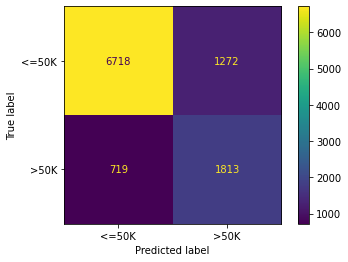

In [47]:
# Pustanje XGBoost-a bez optimizovanih hiperparametara.
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(train_x, train_y)
xgb_predictions = xgb_model.predict(test_x)
xgb_accuracy = accuracy_score(test_y, xgb_predictions)
print("XGB accuracy:", xgb_accuracy)
print(classification_report(test_y, xgb_predictions, target_names=['<=50K', '>50K']))

xgb_cm = confusion_matrix(y_true=test_y, y_pred=xgb_predictions)
xgb_cm_display = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=['<=50K', '>50K'])
xgb_cm_display.plot()
plt.show()

XGB accuracy: 0.8096369511499715
              precision    recall  f1-score   support

       <=50K       0.90      0.85      0.87      7990
        >50K       0.59      0.69      0.64      2532

    accuracy                           0.81     10522
   macro avg       0.74      0.77      0.75     10522
weighted avg       0.82      0.81      0.81     10522



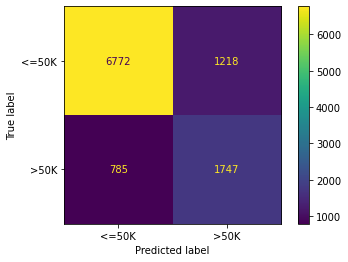

In [48]:
# Pustanje XGBoost-a sa optimizovanim hiperparametrima.
xgb_model = xgb.XGBClassifier(objective="binary:logistic", **xgb_optimized_rf)
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", **xgb_optimized_lasso)
xgb_model.fit(train_x, train_y)
xgb_predictions = xgb_model.predict(test_x)
xgb_accuracy = accuracy_score(test_y, xgb_predictions)
print("XGB accuracy:", xgb_accuracy)
print(classification_report(test_y, xgb_predictions, target_names=['<=50K', '>50K']))

xgb_cm = confusion_matrix(y_true=test_y, y_pred=xgb_predictions)
xgb_cm_display = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=['<=50K', '>50K'])
xgb_cm_display.plot()
plt.show()

### Random Forest

Random Forest accuracy: 0.7869226382816955
              precision    recall  f1-score   support

       <=50K       0.87      0.85      0.86      7990
        >50K       0.55      0.60      0.58      2532

    accuracy                           0.79     10522
   macro avg       0.71      0.72      0.72     10522
weighted avg       0.79      0.79      0.79     10522



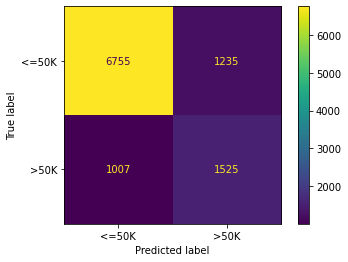

In [49]:
# Pustanje Random Forest-a.
rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)
rf_predictions = rf_model.predict(test_x)
rf_accuracy = accuracy_score(test_y, rf_predictions)
print("Random Forest accuracy:", rf_accuracy)
print(classification_report(test_y, rf_predictions, target_names=['<=50K', '>50K']))

rf_cm = confusion_matrix(y_true=test_y, y_pred=rf_predictions)
rf_cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['<=50K', '>50K'])
rf_cm_display.plot()
plt.show()

### LightGBM

In [243]:
# Nalazenje pribliznih parametara za LightGBM.
lgbm_model = lgbm.LGBMClassifier(objective='binary')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

hyperparams = dict()
hyperparams['boosting_type'] = ['gbdt', 'dart', 'rf']
hyperparams['num_leaves'] = [10, 20, 30, 40, 50]
hyperparams['learning_rate'] = [0.05, 0.1, 0.15, 0.20]
hyperparams['feature_fraction'] = [0.5, 0.6, 0.7, 0.8, 0.9]
hyperparams['importance_type'] = ['split', 'gain']

lgbm_random_cv = RandomizedSearchCV(lgbm_model, hyperparams, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
lgbm_random_result = lgbm_random_cv.fit(train_x, train_y)
print(lgbm_random_result.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 23771, number of negative: 23771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 47542, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [50]:
lgbm_random_optimized_rf = {'num_leaves': 50, 'learning_rate': 0.2, 'importance_type': 'split', 'feature_fraction': 0.6, 'boosting_type': 'gbdt'}

In [246]:
#lgbm_random_optimized_lasso = {'num_leaves': 30, 'learning_rate': 0.2, 'importance_type': 'split', 'feature_fraction': 0.5, 'boosting_type': 'gbdt'}

In [247]:
# Preciznija pretraga parametara za LightGBM.
lgbm_model = lgbm.LGBMClassifier(objective='binary')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Random Forest.
lgbm_param_grid = {
    "num_leaves": [45, 50, 55],
    "learning_rate": np.linspace(0.15, 0.25, 5, endpoint=True),
    "importance_type": ['split'],
    "feature_fraction": np.linspace(0.55, 0.65, 5, endpoint=True),
    "boosting_type": ['gbdt']
}

# Lasso.
# lgbm_param_grid = {
#     "num_leaves": [25, 30, 35],
#     "learning_rate": np.linspace(0.15, 0.25, 5, endpoint=True),
#     "importance_type": ['split'],
#     "feature_fraction": np.linspace(0.45, 0.55, 5, endpoint=True),
#     "boosting_type": ['gbdt']
# }

lgbm_grid_cv = GridSearchCV(lgbm_model, lgbm_param_grid, n_jobs=-1, cv=cv, scoring="roc_auc")
lgbm_grid_result = lgbm_grid_cv.fit(train_x, train_y)
print(lgbm_grid_result.best_score_)
print(lgbm_grid_result.best_params_)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 23771, number of negative: 23771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 47542, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [51]:
lgbm_optimized_rf = {'boosting_type': 'gbdt', 'feature_fraction': 0.55, 'importance_type': 'split', 'learning_rate': 0.2, 'num_leaves': 55}

In [250]:
# lgbm_optimized_lasso = {'boosting_type': 'gbdt', 'feature_fraction': 0.5, 'importance_type': 'split', 'learning_rate': 0.25, 'num_leaves': 30}

[LightGBM] [Info] Number of positive: 23794, number of negative: 23794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 47588, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM accuracy: 0.8139137046188938
              precision    recall  f1-score   support

       <=50K       0.91      0.84      0.87      7990
        >50K       0.59      0.73      0.65      2532

    accuracy                           0.81     10522
   macro avg       0.75      0.79      0.76     10522
weighted avg       0.83      0.81      0.82     10522



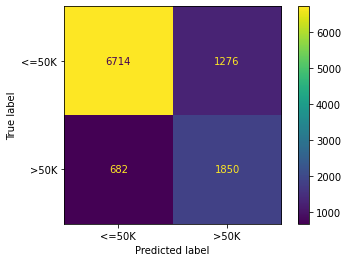

In [52]:
# Pustanje LightGBM bez optimizovanih hiperparametara.
lgbm_model = lgbm.LGBMClassifier()
lgbm_model.fit(train_x, train_y)
lgbm_predictions = lgbm_model.predict(test_x)
lgbm_accuracy = accuracy_score(test_y, lgbm_predictions)
print("LGBM accuracy:", lgbm_accuracy)
print(classification_report(test_y, lgbm_predictions, target_names=['<=50K', '>50K']))

lgbm_cm = confusion_matrix(y_true=test_y, y_pred=lgbm_predictions)
lgbm_cm_display = ConfusionMatrixDisplay(confusion_matrix=lgbm_cm, display_labels=['<=50K', '>50K'])
lgbm_cm_display.plot()
plt.show()

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Info] Number of positive: 23794, number of negative: 23794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 47588, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
LGBM accuracy: 0.8206614712031933
              precision    recall  f1-score   support

       <=50K       0.89      0.

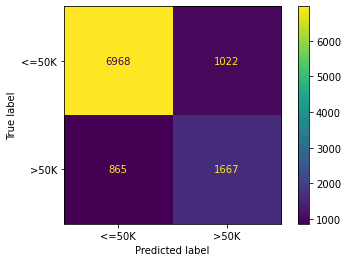

In [53]:
# Pustanje LightGBM.
lgbm_model = lgbm.LGBMClassifier(**lgbm_optimized_rf)
# lgbm_model = lgbm.LGBMClassifier(**lgbm_optimized_lasso)
lgbm_model.fit(train_x, train_y)
lgbm_predictions = lgbm_model.predict(test_x)
lgbm_accuracy = accuracy_score(test_y, lgbm_predictions)
print("LGBM accuracy:", lgbm_accuracy)
print(classification_report(test_y, lgbm_predictions, target_names=['<=50K', '>50K']))

lgbm_cm = confusion_matrix(y_true=test_y, y_pred=lgbm_predictions)
lgbm_cm_display = ConfusionMatrixDisplay(confusion_matrix=lgbm_cm, display_labels=['<=50K', '>50K'])
lgbm_cm_display.plot()
plt.show()

SVC accuracy: 0.7628777798897548
              precision    recall  f1-score   support

       <=50K       0.93      0.74      0.83      7990
        >50K       0.50      0.83      0.63      2532

    accuracy                           0.76     10522
   macro avg       0.72      0.79      0.73     10522
weighted avg       0.83      0.76      0.78     10522



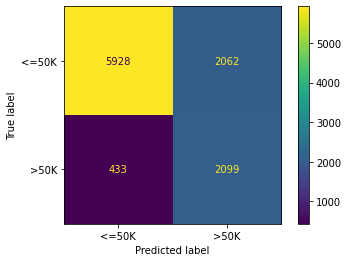

In [54]:
# Pustanje SVC.
svc_model = SVC()
svc_model.fit(train_x, train_y)
svc_predictions = svc_model.predict(test_x)
svc_accuracy = accuracy_score(test_y, svc_predictions)
print("SVC accuracy:", svc_accuracy)
print(classification_report(test_y, svc_predictions, target_names=['<=50K', '>50K']))

svc_cm = confusion_matrix(y_true=test_y, y_pred=svc_predictions)
svc_cm_display = ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=['<=50K', '>50K'])
svc_cm_display.plot()
plt.show()

Bagging Classifier accuracy: 0.782265728948869
              precision    recall  f1-score   support

       <=50K       0.86      0.85      0.86      7990
        >50K       0.55      0.56      0.55      2532

    accuracy                           0.78     10522
   macro avg       0.70      0.70      0.70     10522
weighted avg       0.78      0.78      0.78     10522



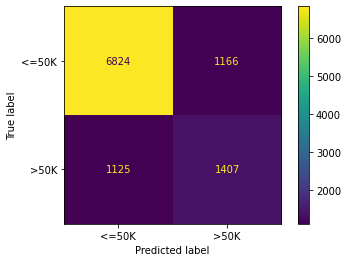

In [55]:
# Pustanje Bagging Classifier-a.
bc_model = BaggingClassifier()
bc_model.fit(train_x, train_y)
bc_predictions = bc_model.predict(test_x)
bc_accuracy = accuracy_score(test_y, bc_predictions)
print("Bagging Classifier accuracy:", bc_accuracy)
print(classification_report(test_y, bc_predictions, target_names=['<=50K', '>50K']))

bc_cm = confusion_matrix(y_true=test_y, y_pred=bc_predictions)
bc_cm_display = ConfusionMatrixDisplay(confusion_matrix=bc_cm, display_labels=['<=50K', '>50K'])
bc_cm_display.plot()
plt.show()

## Cross-validation

In [56]:
# Provera modela i pomocu Stratified K Fold-a.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

xgb_accu_stratified = []
rf_accu_stratified = []
lgbm_accu_stratified = []

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

for train_index, test_index in skf.split(x, labels):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = labels[train_index], labels[test_index]
    
    xgb_model.fit(x_train_fold, y_train_fold)
    xgb_accu_stratified.append(xgb_model.score(x_test_fold, y_test_fold))

    rf_model.fit(x_train_fold, y_train_fold)
    rf_accu_stratified.append(rf_model.score(x_test_fold, y_test_fold))

    lgbm_model.fit(x_train_fold, y_train_fold)
    lgbm_accu_stratified.append(lgbm_model.score(x_test_fold, y_test_fold))

print("XGBoost list of accuracies: ", xgb_accu_stratified)
print("Random Forest list of accuracies: ", rf_accu_stratified)
print("LGBM list of accuracies: ", lgbm_accu_stratified)

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Info] Number of positive: 8242, number of negative: 25427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 33669, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.244795 -> initscore=-1.126569
[LightGBM] [Info] Start training from score -1.126569
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytre

## Ensemble (Voting) Classifier

Na kraju, od kreiranih modela (tri najbolja) napravljen je Ensemble Classifier.

In [57]:
classifiers = [xgb_model, rf_model, lgbm_model]
ensemble = Ensemble(classifiers=classifiers)

In [58]:
combiner = Combiner(rule='majority_vote')

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
Ensemble Classifier accuracy: 0.6831400874358488
              precision    recall  f1-score   support

       <=50K       0.75      0.88      0.81      7990
        >50K       0.15      0.07      0.09      2532

    accuracy                           0.68     10522
   macro avg       0.45      0.47      0.45     10522
weighted avg       0.60      0.68      0.64     10522



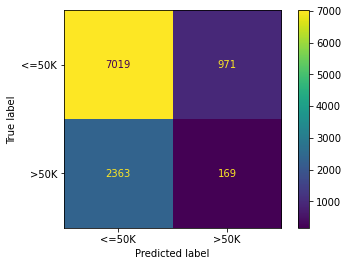

In [59]:
ensemble_classifier = EnsembleClassifier(ensemble=ensemble, combiner=combiner)
ensemble_predictions = ensemble_classifier.predict(test_x)
ensemble_accuracy = accuracy_score(test_y, ensemble_predictions)
print("Ensemble Classifier accuracy:", ensemble_accuracy)
print(classification_report(test_y, ensemble_predictions, target_names=['<=50K', '>50K']))

ensemble_cm = confusion_matrix(y_true=test_y, y_pred=ensemble_predictions)
ensemble_cm_display = ConfusionMatrixDisplay(confusion_matrix=ensemble_cm, display_labels=['<=50K', '>50K'])
ensemble_cm_display.plot()
plt.show()

In [61]:
# Provera modela i pomocu Stratified K Fold-a.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

ensemble_accu_stratified = []

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

for train_index, test_index in skf.split(x, labels):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = labels[train_index], labels[test_index]
    
    ensemble_classifier.fit(x_train_fold, y_train_fold)
    ensemble_accu_stratified.append(ensemble_classifier.score(x_test_fold, y_test_fold))

print("Ensemble classifier list of accuracies: ", ensemble_accu_stratified)

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Info] Number of positive: 8242, number of negative: 25427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 33669, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.244795 -> initscore=-1.126569
[LightGBM] [Info] Start training from score -1.126569
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytre